# Autolabelling Pipeline v2

Want to:
- Create a set of functions for autolabelling
    - E.g. pass a folder of raw images and create a labels file for them
- Make a set of zero-shot classification functions with CLIP/BLIP to label images with several parameters:
    - "edible_food" vs "other"
    - "contains_logo" vs "no_logo"
    - "contains_text" vs "no_text"
    - "contains_human" vs "no_human"
    - "apple", "banana"... etc (for different food classes)
- Want to do this to create a very large dataset of *only* food images 


* **Input:** Raw folder of images.
* **Output:** FoodVision style labels of image with their respective paths.

In [1]:
import open_clip
import torch

print(torch.cuda.is_available())

# open_clip.list_pretrained()

True


In [2]:
# Append the upper level directory to sys
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

import torch

from utils.misc import sort_dict_by_values

from zero_shot_classification import open_clip_compute_image_features_of_list, open_clip_compute_text_features, open_clip_zero_shot_classification, open_clip_get_image_and_text_similarity_dicts

In [3]:
# !unzip 2023-03-03-food_photos.zip

In [42]:
# Find all the filepaths in "2023-03-03-food_photos"
target_dir = Path("2023-03-20-food_photos")
food_photos_filepaths = list(target_dir.rglob("*/*.jp*g"))
len(food_photos_filepaths)

446

In [43]:
food_photos_filepaths

[PosixPath('2023-03-20-food_photos/wombok/90e07d23-af94-45e5-b4b7-a39b08e1fb64.jpeg'),
 PosixPath('2023-03-20-food_photos/wombok/bfaa4d12-977e-4b28-9980-8665615bc64f.jpeg'),
 PosixPath('2023-03-20-food_photos/wombok/af2d1b14-9ed5-46fe-9289-87bd4d513cb5.jpeg'),
 PosixPath('2023-03-20-food_photos/corn_chips/dc59956c-7581-4ba1-9f8a-f4b7b6bcd24b.jpeg'),
 PosixPath('2023-03-20-food_photos/corn_chips/6c935665-d216-47e7-9ba9-da1f0b95c9e2.jpeg'),
 PosixPath('2023-03-20-food_photos/watermelon/6b1d44ee-7323-45b5-b211-49b7f20c354a.jpeg'),
 PosixPath('2023-03-20-food_photos/watermelon/1f3befdc-2530-41e3-bfde-49e467663113.jpeg'),
 PosixPath('2023-03-20-food_photos/sausages/ebd7636d-17f6-40c2-b2be-09568fe5d26a.jpeg'),
 PosixPath('2023-03-20-food_photos/sausages/d8f9fd36-d741-448e-998c-a00bbad86199.jpeg'),
 PosixPath('2023-03-20-food_photos/salt/a6531be3-f4c2-4501-8fc0-6bae22af0083.jpeg'),
 PosixPath('2023-03-20-food_photos/salt/e07bfa89-9bd6-4063-b5e4-1cc7366b31d3.jpeg'),
 PosixPath('2023-03-20-food

In [44]:
target_dir = Path(target_dir)

# Image paths
image_paths = list(target_dir.rglob("*.jp*g"))
print(f"Number of images: {len(image_paths)}")

# Go through image paths and make sure they're all UUIDs for the names, otherwise rename them to UUIDs
import uuid

def is_valid_uuid(string):
    try:
        uuid.UUID(string)
        return True
    except ValueError:
        return False

# Loop through all_paths, if the path is a UUID, pass, if not, rename the file to a UUID
for path in image_paths:
    if not is_valid_uuid(path.stem):
        print(f"[INFO] {path} isn't valud UUID, renaming to UUID...")
        new_name = f"{uuid.uuid4()}.jpeg"
        new_path_name = path.parent / new_name
        path.rename(new_path_name)
        print(f"[INFO] Renamed {path} to {new_path_name}")

# Image paths
image_paths = list(target_dir.rglob("*.jp*g"))
print(f"Number of images: {len(image_paths)}")

Number of images: 446
Number of images: 446


In [7]:
# Get original labels to label new data from
# Get config
from configs.default_config import config

args = config

# Connect to GCP
from utils.gcp_utils import set_gcp_credentials, test_gcp_connection
set_gcp_credentials(path_to_key="../utils/google-storage-key.json")
test_gcp_connection()

import wandb

# Initialize a new run
from utils.wandb_utils import wandb_load_artifact, wandb_download_and_load_labels

notes = f"test zero-shot classification with new images"

run = wandb.init(project=args.wandb_project, 
                 job_type=args.wandb_job_type,
                 tags=['auto_label_new_images'],
                 notes=notes)

annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

len(annotations.label.unique())

[INFO] GCP credentials set!
[INFO] GCP connection successful! Access to GCP for saving/loading data and models available.


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrdbourke. Use `wandb login --relogin` to force relogin


[INFO] Labels directory: ./artifacts/food_vision_labels:v55
[INFO] Labels path: artifacts/food_vision_labels:v55/annotations.csv
[INFO] Working with: 293 classes


293

In [45]:
extra_image_path_class_names = []
for image_path in image_paths:
    extra_image_path_class_names.append(image_path.parent.name)

extra_image_path_class_names = list(set(extra_image_path_class_names))

In [46]:
"yam_okinawan" in extra_image_path_class_names

False

In [47]:
# Create a list of existing class names plus add "other" for examples that don't fit into any of the existing classes
class_names_and_other = sorted(list(set(class_names + ["other", "not_food"] + extra_image_path_class_names)))

print(f"Number of class names and other: {len(class_names_and_other)}")
import random
print(f"Here's a random 10: {random.sample(class_names_and_other, 10)}")
print(f"And here's the ones that aren't in the original class names:\n{sorted(list(set(class_names_and_other) - set(class_names)))}")

text_features = open_clip_compute_text_features(class_names_and_other)

Number of class names and other: 302
Here's a random 10: ['pork_chop', 'choko', 'basil', 'mushroom_white_cups', 'potato_white', 'biltong', 'burrito', 'tacos', 'papaya', 'peanuts']
And here's the ones that aren't in the original class names:
['chicken_burger', 'cocoa_powder', 'melon_bitter', 'milkshake', 'mushroom_flat', 'not_food', 'other', 'squash_spaghetti', 'tuna']


In [48]:
from typing import List
from tqdm.auto import tqdm

def open_clip_get_image_and_text_similarity_dicts(open_clip_image_features_list: list,
                                                  target_classes: List[str],
                                                  max_len_of_similarity_dict: int = 10):
    
    # Set CLIP and BLIP to use GPU for creating image features if available
    # img_feature_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Encode text features on CPU (this is quick even for 100s of classes)
    # blip_text_features = blip_get_text_features(text=target_classes, device="cpu") # only get dims for zero-shot classification
    open_clip_text_features = open_clip_compute_text_features(text=target_classes)
    
    # Loop through image paths
    auto_created_labels = []
    for image_feature_dict in tqdm(open_clip_image_features_list, desc="Calculating image features and similarity dicts"):

        image_path = image_feature_dict["image_path"]
        # Match image path to pre-computed image features
        # print(image_paths.index(image_path))
        open_clip_img_features = image_feature_dict["image_features"]
        # blip_img_features = blip_image_features_list[image_paths.index(image_path)]["image_features"][:, 0] # TODO: could the indexing be cleaner?
        
        # Get sorted similarity dicts
        open_clip_similarity_dict = open_clip_zero_shot_classification(open_clip_img_features, open_clip_text_features, target_classes, sorted=True)
        # blip_similarity_dict = blip_zero_shot_classification(blip_img_features, blip_text_features, target_classes, sorted=True)

        # # Average the values of the similarity dicts
        # avg_similarity_dict = {}
        # for key in open_clip_similarity_dict.keys():
        #     avg_similarity_dict[key] = (open_clip_similarity_dict[key] + blip_similarity_dict[key]) / 2
        
        # # Sort the average similarity dict and reduce length to 5
        # avg_similarity_dict = dict(list(sort_dict_by_values(avg_similarity_dict).items())[:5])

        # If the length of the similarity dicts is max_len_of_similarity_dict, shorten it
        if len(open_clip_similarity_dict) > max_len_of_similarity_dict:
            open_clip_similarity_dict = dict(list(open_clip_similarity_dict.items())[:max_len_of_similarity_dict])
        
        # if len(blip_similarity_dict) > 5:
        #     blip_similarity_dict = dict(list(blip_similarity_dict.items())[:5])
        
        # Append to list
        auto_created_labels.append({"image_path": image_path,
                                    "image_name": image_path.name,
                                    # "blip_sorted_similarity_dict": blip_similarity_dict,
                                    # "blip_top_1_class_name": list(blip_similarity_dict.keys())[0],
                                    # "blip_top_1_similarity_score": list(blip_similarity_dict.values())[0],
                                    "open_clip_sorted_similarity_dict": open_clip_similarity_dict,
                                    "open_clip_top_1_class_name": list(open_clip_similarity_dict.keys())[0],
                                    "open_clip_top_1_similarity_score": list(open_clip_similarity_dict.values())[0],
                                    # "avg_sorted_similarity_dict": avg_similarity_dict,
                                    # "avg_top_1_class_name": list(avg_similarity_dict.keys())[0],
                                    # "avg_top_1_similarity_score": list(avg_similarity_dict.values())[0]
                                })
    
    return auto_created_labels

In [49]:
# Pre-compute features of all images in list (to save computing on the fly, can then just do index-matching)
open_clip_image_features_list = open_clip_compute_image_features_of_list(image_paths=image_paths, device="cuda")

Computing OpenCLIP image features:   0%|          | 0/446 [00:00<?, ?it/s]

In [50]:
# Get similarity dicts
image_and_text_similarity_dicts = open_clip_get_image_and_text_similarity_dicts(open_clip_image_features_list=open_clip_image_features_list,
                                                                                target_classes=class_names_and_other)

Calculating image features and similarity dicts:   0%|          | 0/446 [00:00<?, ?it/s]

In [51]:
# Turn the similarity dicts into a dataframe
import pandas as pd
image_and_text_similarity_df = pd.DataFrame(image_and_text_similarity_dicts)
image_and_text_similarity_df.head()

image_path  \
0  2023-03-20-food_photos/wombok/90e07d23-af94-45...   
1  2023-03-20-food_photos/wombok/bfaa4d12-977e-4b...   
2  2023-03-20-food_photos/wombok/af2d1b14-9ed5-46...   
3  2023-03-20-food_photos/corn_chips/dc59956c-758...   
4  2023-03-20-food_photos/corn_chips/6c935665-d21...   

                                  image_name  \
0  90e07d23-af94-45e5-b4b7-a39b08e1fb64.jpeg   
1  bfaa4d12-977e-4b28-9980-8665615bc64f.jpeg   
2  af2d1b14-9ed5-46fe-9289-87bd4d513cb5.jpeg   
3  dc59956c-7581-4ba1-9f8a-f4b7b6bcd24b.jpeg   
4  6c935665-d216-47e7-9ba9-da1f0b95c9e2.jpeg   

                    open_clip_sorted_similarity_dict  \
0  {'endive_curly': 0.25526943802833557, 'endive_...   
1  {'bok_choy': 0.24890992045402527, 'lettuce_cos...   
2  {'cabbage_red': 0.5172996520996094, 'savoy_cab...   
3  {'corn_chips': 0.9987612962722778, 'potato_chi...   
4  {'corn_chips': 0.9965482354164124, 'potato_chi...   

  open_clip_top_1_class_name  open_clip_top_1_similarity_score  
0               endive_curly                          0.255269  
1                   bok_choy                          0.248910  
2                cabbage_red                          0.517300  
3                 corn_chips                          0.998761  
4                 corn_chips                          0.996548

In [52]:
image_and_text_similarity_df.open_clip_top_1_class_name.value_counts()

plum               14
ice_coffee         14
cheese             11
lettuce_cos        10
brownie            10
                   ..
eggplant            1
capsicum_orange     1
pork_roast          1
pork_belly          1
shallots            1
Name: open_clip_top_1_class_name, Length: 144, dtype: int64

In [53]:
image_and_text_similarity_df.query("open_clip_top_1_class_name == 'ginger'")

Empty DataFrame
Columns: [image_path, image_name, open_clip_sorted_similarity_dict, open_clip_top_1_class_name, open_clip_top_1_similarity_score]
Index: []

In [54]:
maybe_not_food = image_and_text_similarity_df[image_and_text_similarity_df["open_clip_sorted_similarity_dict"].apply(lambda x: "not_food" in list(x.keys())[:3] or "other" in list(x.keys())[:3])]
len(maybe_not_food)

0

In [55]:
maybe_not_food.query("open_clip_top_1_similarity_score < 0.98")

Empty DataFrame
Columns: [image_path, image_name, open_clip_sorted_similarity_dict, open_clip_top_1_class_name, open_clip_top_1_similarity_score]
Index: []

In [56]:
# Add a column of "true_label" with is the parent classes of image_path
image_and_text_similarity_df["true_label"] = image_and_text_similarity_df["image_path"].apply(lambda x: str(x).split("/")[-2])

# Find the accuracy of rows with top 1 similarity score over 0.98
# image_and_text_similarity_df["top_1_accuracy"] = image_and_text_similarity_df.apply(lambda x: x["true_label"] == x["open_clip_top_1_class_name"], axis=1)
over_98 = image_and_text_similarity_df[image_and_text_similarity_df["open_clip_top_1_similarity_score"] > 0.98]

# Find the accuracy of rows with top 1 similarity score over 0.98
len(over_98[over_98["true_label"] == over_98["open_clip_top_1_class_name"]]) / len(over_98)

1.0

In [57]:
# Find the accuracy of all rows
len(image_and_text_similarity_df[image_and_text_similarity_df["true_label"] == image_and_text_similarity_df["open_clip_top_1_class_name"]]) / len(image_and_text_similarity_df)

0.7174887892376681

In [58]:
image_and_text_similarity_df.query("true_label == open_clip_top_1_class_name and open_clip_top_1_similarity_score > 0.98")

image_path  \
3    2023-03-20-food_photos/corn_chips/dc59956c-758...   
4    2023-03-20-food_photos/corn_chips/6c935665-d21...   
8    2023-03-20-food_photos/sausages/d8f9fd36-d741-...   
14   2023-03-20-food_photos/salt/63d8e35b-fe20-4c24...   
16   2023-03-20-food_photos/starfruit/7b7e62f8-d4f7...   
..                                                 ...   
431  2023-03-20-food_photos/ice_coffee/1631633f-ed7...   
432  2023-03-20-food_photos/ice_coffee/c420e499-ea4...   
436  2023-03-20-food_photos/ice_coffee/99483b5a-83e...   
437  2023-03-20-food_photos/ice_coffee/e6b19dbf-83e...   
439  2023-03-20-food_photos/ice_coffee/b8dcce37-b13...   

                                    image_name  \
3    dc59956c-7581-4ba1-9f8a-f4b7b6bcd24b.jpeg   
4    6c935665-d216-47e7-9ba9-da1f0b95c9e2.jpeg   
8    d8f9fd36-d741-448e-998c-a00bbad86199.jpeg   
14   63d8e35b-fe20-4c24-a08c-a8e13fc24e55.jpeg   
16   7b7e62f8-d4f7-4ec4-a6d7-0af2593d5af0.jpeg   
..                                         ...   
431  1631633f-ed74-448c-8951-51097c839fbf.jpeg   
432  c420e499-ea48-44c6-8a3f-a0a70b0e3ca3.jpeg   
436  99483b5a-83ef-4cfe-8d75-858bba9e32f2.jpeg   
437  e6b19dbf-83e1-43bb-8ec0-9d7b7739e0e2.jpeg   
439  b8dcce37-b137-452d-90bc-0bedc040176a.jpeg   

                      open_clip_sorted_similarity_dict  \
3    {'corn_chips': 0.9987612962722778, 'potato_chi...   
4    {'corn_chips': 0.9965482354164124, 'potato_chi...   
8    {'sausages': 0.9990569949150085, 'pork_loins':...   
14   {'salt': 0.9974919557571411, 'ham': 0.00164706...   
16   {'starfruit': 0.9975237250328064, 'passionfrui...   
..                                                 ...   
431  {'ice_coffee': 0.9944148063659668, 'coffee': 0...   
432  {'ice_coffee': 0.9963724613189697, 'orange_jui...   
436  {'ice_coffee': 0.9939637780189514, 'coffee': 0...   
437  {'ice_coffee': 0.9825221300125122, 'coffee': 0...   
439  {'ice_coffee': 0.9804953932762146, 'beer': 0.0...   

    open_clip_top_1_class_name  open_clip_top_1_similarity_score  true_label  
3                   corn_chips                          0.998761  corn_chips  
4                   corn_chips                          0.996548  corn_chips  
8                     sausages                          0.999057    sausages  
14                        salt                          0.997492        salt  
16                   starfruit                          0.997524   starfruit  
..                         ...                               ...         ...  
431                 ice_coffee                          0.994415  ice_coffee  
432                 ice_coffee                          0.996372  ice_coffee  
436                 ice_coffee                          0.993964  ice_coffee  
437                 ice_coffee                          0.982522  ice_coffee  
439                 ice_coffee                          0.980495  ice_coffee  

[147 rows x 6 columns]

In [59]:
# Get rows that are wrong
wrong_rows = image_and_text_similarity_df.query("true_label != open_clip_top_1_class_name")
wrong_rows

image_path  \
0    2023-03-20-food_photos/wombok/90e07d23-af94-45...   
1    2023-03-20-food_photos/wombok/bfaa4d12-977e-4b...   
2    2023-03-20-food_photos/wombok/af2d1b14-9ed5-46...   
10   2023-03-20-food_photos/salt/e07bfa89-9bd6-4063...   
12   2023-03-20-food_photos/salt/9b1558d2-a89f-46cd...   
..                                                 ...   
429  2023-03-20-food_photos/ice_coffee/0b0924e4-464...   
430  2023-03-20-food_photos/ice_coffee/cdf3c65e-894...   
440  2023-03-20-food_photos/ice_coffee/129d1b92-d88...   
442  2023-03-20-food_photos/onion_brown/de2464b6-c1...   
445  2023-03-20-food_photos/onion_brown/a5a40b4f-d0...   

                                    image_name  \
0    90e07d23-af94-45e5-b4b7-a39b08e1fb64.jpeg   
1    bfaa4d12-977e-4b28-9980-8665615bc64f.jpeg   
2    af2d1b14-9ed5-46fe-9289-87bd4d513cb5.jpeg   
10   e07bfa89-9bd6-4063-b5e4-1cc7366b31d3.jpeg   
12   9b1558d2-a89f-46cd-a664-561e3a3ad37c.jpeg   
..                                         ...   
429  0b0924e4-4645-4a49-8131-b9c4b3f990b3.jpeg   
430  cdf3c65e-894c-4fec-9cb5-e476f170ecac.jpeg   
440  129d1b92-d885-4117-b26a-3324ac88bd2e.jpeg   
442  de2464b6-c167-4fa7-a6a7-a3b73865176e.jpeg   
445  a5a40b4f-d017-474d-812a-024e44bf6632.jpeg   

                      open_clip_sorted_similarity_dict  \
0    {'endive_curly': 0.25526943802833557, 'endive_...   
1    {'bok_choy': 0.24890992045402527, 'lettuce_cos...   
2    {'cabbage_red': 0.5172996520996094, 'savoy_cab...   
10   {'milkshake': 0.28539833426475525, 'soy_sauce'...   
12   {'soy_sauce': 0.1504930704832077, 'salt': 0.12...   
..                                                 ...   
429  {'beer': 0.6387791633605957, 'orange_juice': 0...   
430  {'beer': 0.4744148850440979, 'orange_juice': 0...   
440  {'beer': 0.6939375996589661, 'ice_coffee': 0.2...   
442  {'shallots': 0.7907471656799316, 'onion_brown'...   
445  {'onion_red': 0.8817024827003479, 'shallots': ...   

    open_clip_top_1_class_name  open_clip_top_1_similarity_score   true_label  
0                 endive_curly                          0.255269       wombok  
1                     bok_choy                          0.248910       wombok  
2                  cabbage_red                          0.517300       wombok  
10                   milkshake                          0.285398         salt  
12                   soy_sauce                          0.150493         salt  
..                         ...                               ...          ...  
429                       beer                          0.638779   ice_coffee  
430                       beer                          0.474415   ice_coffee  
440                       beer                          0.693938   ice_coffee  
442                   shallots                          0.790747  onion_brown  
445                  onion_red                          0.881702  onion_brown  

[126 rows x 6 columns]

In [60]:
len(wrong_rows)

126

In [61]:
# Show the rows in wrong_rows where the prediction is "taro"
wrong_rows.query("open_clip_top_1_class_name == 'pistachio'")

Empty DataFrame
Columns: [image_path, image_name, open_clip_sorted_similarity_dict, open_clip_top_1_class_name, open_clip_top_1_similarity_score, true_label]
Index: []

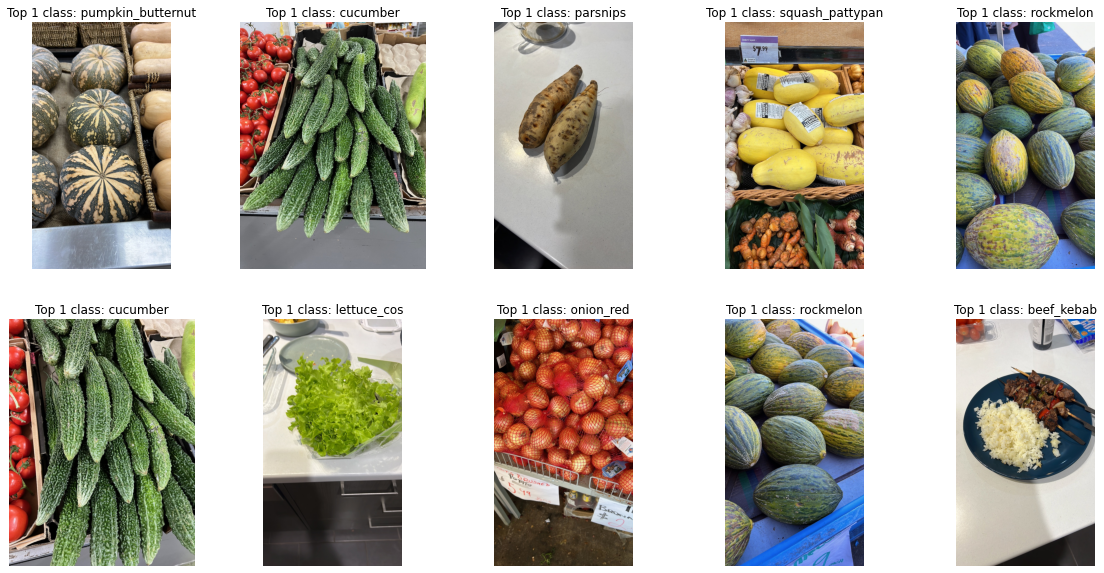

In [66]:
# Plot 10 random images with their top 1 class_name
import matplotlib.pyplot as plt

def plot_10_random_images_from_df(df, image_path_col="image_name", title_col=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))
    for i, row in enumerate(df.sample(10).iterrows()):
        row = row[1]
        # print(i)
        ax[i // 5, i % 5].imshow(plt.imread(row["image_path"]))
        ax[i // 5, i % 5].set_title(f"Top 1 class: {row[title_col]}")
        ax[i // 5, i % 5].axis(False)

plot_10_random_images_from_df(df=wrong_rows, image_path_col="image_path", title_col="open_clip_top_1_class_name")
    # ax[i // 5, i % 5].set_yticks([])

In [111]:
[class_name for class_name in class_names if "pistachio" in class_name]

['pistachio']

In [112]:
# Create a copy of annotations
original_annotations = annotations.copy()

TODO: make some logic here for images that pass through the food test to get marked as:
* whole_food or dish
* single_food or multiple_foods

In [113]:
# Get similarity dicts
whole_food_or_dish_map = {"whole_food": "whole_food",
                          "not_whole_food": "dish",
                          "other": "other"}
image_and_text_similarity_dicts_whole_food_or_dish = open_clip_get_image_and_text_similarity_dicts(open_clip_image_features_list=open_clip_image_features_list,
                                                                                                   target_classes=["whole_food", "not_whole_food", "other"])

for image_and_text_dict in image_and_text_similarity_dicts_whole_food_or_dish:
    image_and_text_dict["whole_food_or_dish"] = whole_food_or_dish_map[image_and_text_dict["open_clip_top_1_class_name"]]

Calculating image features and similarity dicts:   0%|          | 0/190 [00:00<?, ?it/s]

In [114]:
image_and_text_similarity_dicts_whole_food_or_dish[0]

{'image_path': PosixPath('2023-03-14-food_photos/watermelon/7e7adb76-a8ed-4f2d-b408-07468854ff63.jpeg'),
 'image_name': '7e7adb76-a8ed-4f2d-b408-07468854ff63.jpeg',
 'open_clip_sorted_similarity_dict': {'whole_food': 0.8544859886169434,
  'not_whole_food': 0.13103967905044556,
  'other': 0.01447430718690157},
 'open_clip_top_1_class_name': 'whole_food',
 'open_clip_top_1_similarity_score': 0.8544859886169434,
 'whole_food_or_dish': 'whole_food'}

In [115]:
# Turn the similarity dicts into a dataframe
import pandas as pd
image_and_text_similarity_df_whole_food_or_dish = pd.DataFrame(image_and_text_similarity_dicts_whole_food_or_dish)
image_and_text_similarity_df_whole_food_or_dish.head()

image_path  \
0  2023-03-14-food_photos/watermelon/7e7adb76-a8e...   
1  2023-03-14-food_photos/watermelon/e1c1c319-486...   
2  2023-03-14-food_photos/salt/36bab3c9-2ec0-41a2...   
3  2023-03-14-food_photos/salt/f061158a-352c-4471...   
4  2023-03-14-food_photos/chicken_stir_fry/db1912...   

                                  image_name  \
0  7e7adb76-a8ed-4f2d-b408-07468854ff63.jpeg   
1  e1c1c319-4862-439b-95d6-81694afddaa1.jpeg   
2  36bab3c9-2ec0-41a2-a733-e13d883e7e44.jpeg   
3  f061158a-352c-4471-8cb7-71d3209ee5f2.jpeg   
4  db1912c2-b1f3-48fa-bb51-d5b199ebd2d8.jpeg   

                    open_clip_sorted_similarity_dict  \
0  {'whole_food': 0.8544859886169434, 'not_whole_...   
1  {'whole_food': 0.8097341060638428, 'not_whole_...   
2  {'other': 0.6699761748313904, 'whole_food': 0....   
3  {'whole_food': 0.5487558245658875, 'other': 0....   
4  {'whole_food': 0.5603594779968262, 'not_whole_...   

  open_clip_top_1_class_name  open_clip_top_1_similarity_score  \
0                 whole_food                          0.854486   
1                 whole_food                          0.809734   
2                      other                          0.669976   
3                 whole_food                          0.548756   
4                 whole_food                          0.560359   

  whole_food_or_dish  
0         whole_food  
1         whole_food  
2              other  
3         whole_food  
4         whole_food

In [116]:
image_and_text_similarity_df_whole_food_or_dish.open_clip_top_1_class_name.value_counts()

whole_food        114
not_whole_food     57
other              19
Name: open_clip_top_1_class_name, dtype: int64

In [117]:
# Show examples of images that were classified as "not_whole_food"
image_and_text_similarity_df_whole_food_or_dish[image_and_text_similarity_df_whole_food_or_dish.open_clip_top_1_class_name == "not_whole_food"].head()

image_path  \
12  2023-03-14-food_photos/cashews/31ad464a-669d-4...   
22  2023-03-14-food_photos/avocado/b883ad83-b695-4...   
23  2023-03-14-food_photos/avocado/c2189d4d-13c9-4...   
24  2023-03-14-food_photos/avocado/229e8053-9c96-4...   
32  2023-03-14-food_photos/zucchini/07e1dcaf-1b81-...   

                                   image_name  \
12  31ad464a-669d-41de-b514-b147dd54d6f5.jpeg   
22  b883ad83-b695-4e5f-8fd6-ad1a8e993b87.jpeg   
23  c2189d4d-13c9-47d1-b0c6-ce06d5e07b30.jpeg   
24  229e8053-9c96-49d7-9237-8e8cb36a5090.jpeg   
32  07e1dcaf-1b81-424f-9085-5b96472652df.jpeg   

                     open_clip_sorted_similarity_dict  \
12  {'not_whole_food': 0.6222526431083679, 'whole_...   
22  {'not_whole_food': 0.6542895436286926, 'whole_...   
23  {'not_whole_food': 0.7275933623313904, 'whole_...   
24  {'not_whole_food': 0.7819839715957642, 'whole_...   
32  {'not_whole_food': 0.5327081084251404, 'whole_...   

   open_clip_top_1_class_name  open_clip_top_1_similarity_score  \
12             not_whole_food                          0.622253   
22             not_whole_food                          0.654290   
23             not_whole_food                          0.727593   
24             not_whole_food                          0.781984   
32             not_whole_food                          0.532708   

   whole_food_or_dish  
12               dish  
22               dish  
23               dish  
24               dish  
32               dish

One food or multiple?

In [118]:
original_annotations.one_food_or_multiple.value_counts()

one_food          8185
multiple_foods     124
dish                 1
Name: one_food_or_multiple, dtype: int64

In [119]:
# Get similarity dicts
single_food_or_multiple_food_map = {"single_type_of_food": "one_food",
                                    "multiple_types_of_foods": "multiple_foods",
                                    "other": "other"}

image_and_text_similarity_dicts_one_food_or_multiple = open_clip_get_image_and_text_similarity_dicts(open_clip_image_features_list=open_clip_image_features_list,
                                                                                                     target_classes=["single_type_of_food", "multiple_types_of_foods", "other"])

for image_and_text_dict in image_and_text_similarity_dicts_one_food_or_multiple:
    image_and_text_dict["one_food_or_multiple"] = single_food_or_multiple_food_map[image_and_text_dict["open_clip_top_1_class_name"]]

Calculating image features and similarity dicts:   0%|          | 0/190 [00:00<?, ?it/s]

In [120]:
image_and_text_similarity_dicts_one_food_or_multiple[0]

{'image_path': PosixPath('2023-03-14-food_photos/watermelon/7e7adb76-a8ed-4f2d-b408-07468854ff63.jpeg'),
 'image_name': '7e7adb76-a8ed-4f2d-b408-07468854ff63.jpeg',
 'open_clip_sorted_similarity_dict': {'multiple_types_of_foods': 0.4864586591720581,
  'single_type_of_food': 0.4032883942127228,
  'other': 0.11025290936231613},
 'open_clip_top_1_class_name': 'multiple_types_of_foods',
 'open_clip_top_1_similarity_score': 0.4864586591720581,
 'one_food_or_multiple': 'multiple_foods'}

In [121]:
# Check to see if any images contain people
image_and_text_similarity_dicts_person_not_person = open_clip_get_image_and_text_similarity_dicts(open_clip_image_features_list=open_clip_image_features_list,
                                                                                                     target_classes=["contains_person", "no_person"])

Calculating image features and similarity dicts:   0%|          | 0/190 [00:00<?, ?it/s]

In [122]:
person_not_person_df = pd.DataFrame(image_and_text_similarity_dicts_person_not_person)
person_not_person_df.head()

image_path  \
0  2023-03-14-food_photos/watermelon/7e7adb76-a8e...   
1  2023-03-14-food_photos/watermelon/e1c1c319-486...   
2  2023-03-14-food_photos/salt/36bab3c9-2ec0-41a2...   
3  2023-03-14-food_photos/salt/f061158a-352c-4471...   
4  2023-03-14-food_photos/chicken_stir_fry/db1912...   

                                  image_name  \
0  7e7adb76-a8ed-4f2d-b408-07468854ff63.jpeg   
1  e1c1c319-4862-439b-95d6-81694afddaa1.jpeg   
2  36bab3c9-2ec0-41a2-a733-e13d883e7e44.jpeg   
3  f061158a-352c-4471-8cb7-71d3209ee5f2.jpeg   
4  db1912c2-b1f3-48fa-bb51-d5b199ebd2d8.jpeg   

                    open_clip_sorted_similarity_dict  \
0  {'contains_person': 0.7905303239822388, 'no_pe...   
1  {'contains_person': 0.6261242032051086, 'no_pe...   
2  {'contains_person': 0.7074047327041626, 'no_pe...   
3  {'contains_person': 0.9314625263214111, 'no_pe...   
4  {'contains_person': 0.9609517455101013, 'no_pe...   

  open_clip_top_1_class_name  open_clip_top_1_similarity_score  
0            contains_person                          0.790530  
1            contains_person                          0.626124  
2            contains_person                          0.707405  
3            contains_person                          0.931463  
4            contains_person                          0.960952

In [123]:
person_not_person_df.open_clip_top_1_class_name.value_counts()

no_person          105
contains_person     85
Name: open_clip_top_1_class_name, dtype: int64

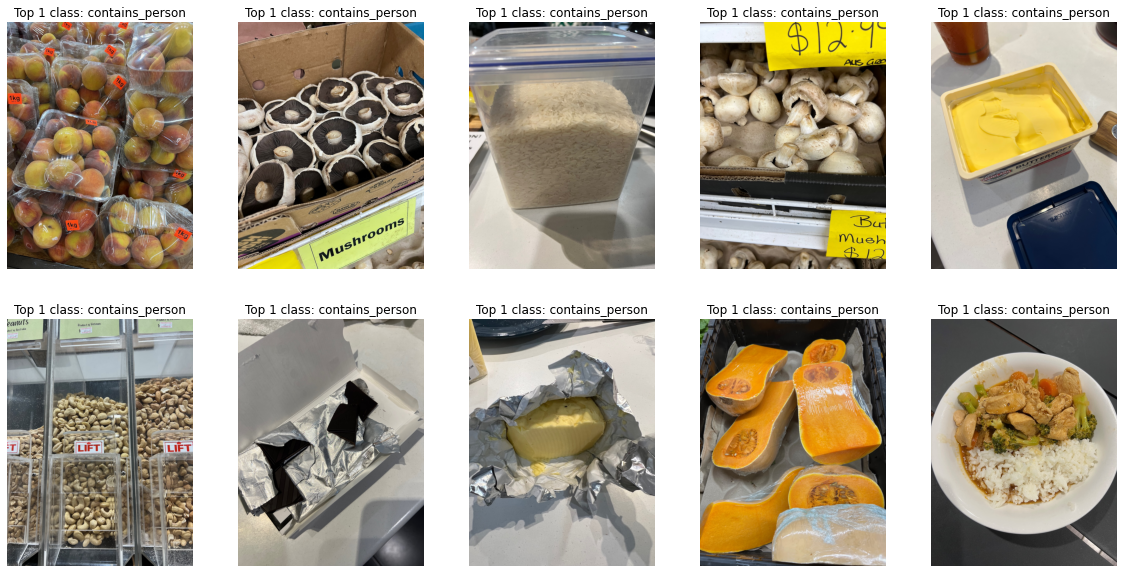

In [125]:
# Plot 10 random images with their top 1 class_name
import matplotlib.pyplot as plt

def plot_10_random_images_from_df(df, image_path_col="image_name", title_col=None):
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))
    for i, row in enumerate(df.sample(10).iterrows()):
        row = row[1]
        # print(i)
        ax[i // 5, i % 5].imshow(plt.imread(row["image_path"]))
        ax[i // 5, i % 5].set_title(f"Top 1 class: {row[title_col]}")
        ax[i // 5, i % 5].axis(False)

plot_10_random_images_from_df(df=person_not_person_df[person_not_person_df["open_clip_top_1_class_name"] == "contains_person"], image_path_col="image_path", title_col="open_clip_top_1_class_name")

In [97]:
# Check to see if any images contain people
image_and_text_similarity_dicts_watermark_no_watermark = open_clip_get_image_and_text_similarity_dicts(open_clip_image_features_list=open_clip_image_features_list,
                                                                                                     target_classes=["watermark", "no_watermark"])

Calculating image features and similarity dicts:   0%|          | 0/706 [00:00<?, ?it/s]

In [98]:
watermark_no_watermark_df = pd.DataFrame(image_and_text_similarity_dicts_watermark_no_watermark)
watermark_no_watermark_df.head()

image_path  \
0  celery/680fdf88-d0ed-44f4-9a00-2d4df8d21d5c.jpeg   
1  celery/08e03f20-a6fe-4b03-9c35-ac38aa24a77b.jpeg   
2  celery/05238860-4402-4299-bdd0-1b8231e2c92f.jpeg   
3  celery/e089d67e-a198-4028-a31d-b4f0292bbfc2.jpeg   
4  celery/f0605c4f-eaed-4a06-8b99-7de06e055bf6.jpeg   

                                  image_name  \
0  680fdf88-d0ed-44f4-9a00-2d4df8d21d5c.jpeg   
1  08e03f20-a6fe-4b03-9c35-ac38aa24a77b.jpeg   
2  05238860-4402-4299-bdd0-1b8231e2c92f.jpeg   
3  e089d67e-a198-4028-a31d-b4f0292bbfc2.jpeg   
4  f0605c4f-eaed-4a06-8b99-7de06e055bf6.jpeg   

                    open_clip_sorted_similarity_dict  \
0  {'watermark': 0.5389832258224487, 'no_watermar...   
1  {'watermark': 0.5234203934669495, 'no_watermar...   
2  {'watermark': 0.9362850189208984, 'no_watermar...   
3  {'no_watermark': 0.66888028383255, 'watermark'...   
4  {'no_watermark': 0.5156199336051941, 'watermar...   

  open_clip_top_1_class_name  open_clip_top_1_similarity_score  
0                  watermark                          0.538983  
1                  watermark                          0.523420  
2                  watermark                          0.936285  
3               no_watermark                          0.668880  
4               no_watermark                          0.515620

In [102]:
watermark_no_watermark_df.open_clip_top_1_class_name.value_counts()

no_watermark    416
watermark       290
Name: open_clip_top_1_class_name, dtype: int64

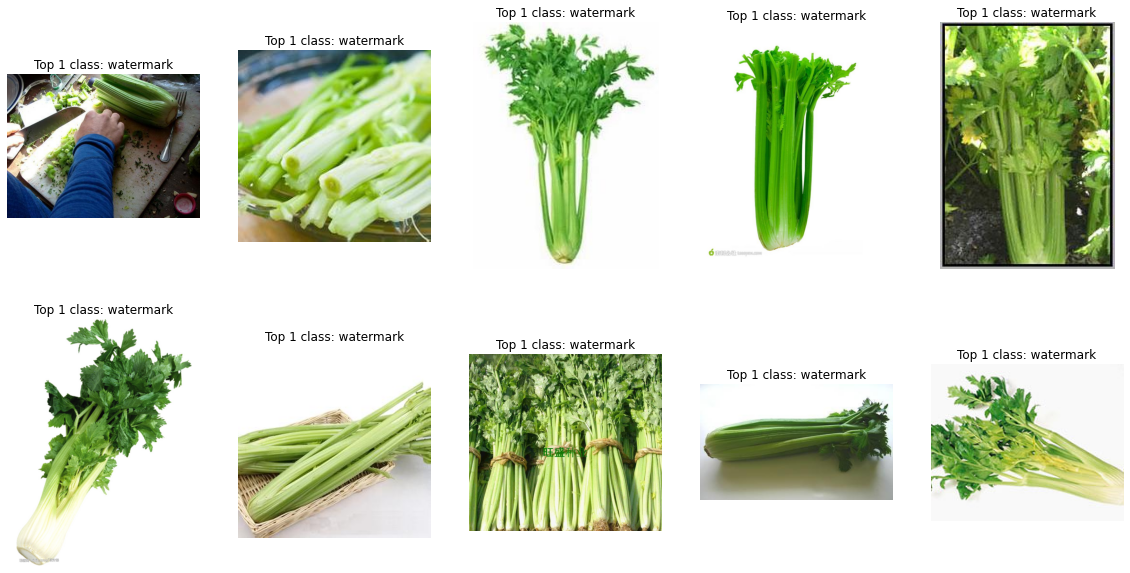

wandb: Network error (ReadTimeout), entering retry loop.


In [119]:
# Plot 10 random images with their top 1 class_name
import matplotlib.pyplot as plt

def plot_10_random_images_from_df(df, image_path_col="image_name", title_col=None):
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))
    for i, row in enumerate(df.sample(10).iterrows()):
        row = row[1]
        # print(i)
        ax[i // 5, i % 5].imshow(plt.imread(row["image_path"]))
        ax[i // 5, i % 5].set_title(f"Top 1 class: {row[title_col]}")
        ax[i // 5, i % 5].axis(False)

plot_10_random_images_from_df(df=watermark_no_watermark_df[watermark_no_watermark_df["open_clip_top_1_class_name"] == "watermark"], image_path_col="image_path", title_col="open_clip_top_1_class_name")

### Create labels across all images

In [82]:
# Next
# Sort out the sorting logic
# Create label dicts for each image (automatically)
# Label each image with CLIP labels of top_1
# Put images that contain not_food or other in a separate folder (don't add these to the dataset) - only do this if their clip score is under 0.98 (if over 0.98, proceed with autolabeling)
# Upload images to all_images bucket
# Write code to filter all_images for wrong labels/duplicate data etc with CleanLabels


# NOTE: CLIP can be used to create noisy/weak labels (these labels don't necessarily have to be perfect)

In [83]:
from utils.misc import get_now_time

maybe_not_food = []
auto_labelled_image_dicts = []
for image_and_text_dict in tqdm(image_and_text_similarity_dicts):
    top_3_clip_list = list(image_and_text_dict["open_clip_sorted_similarity_dict"].keys())[:3]
    if "not_food" in top_3_clip_list or "other" in top_3_clip_list:
        if image_and_text_dict["open_clip_top_1_similarity_score"] < 0.98:
            maybe_not_food.append(image_and_text_dict)
    else:
        image_dict = {}
        image_name = image_and_text_dict["image_name"]
        image_dict["image_name"] = image_name
        image_dict["filename"] = image_and_text_dict["image_path"]
        image_dict['class_name'] = image_and_text_dict["open_clip_top_1_class_name"]
        image_dict['label'] = reverse_class_dict[image_dict["class_name"]]
        
        # Label 20% of the images as test
        if np.random.random() < 0.2:
            image_dict['split'] = 'test'
        else:
            image_dict['split'] = 'train'
        # image_dict['clear_or_confusing'] = 'clear'
        image_dict['whole_food_or_dish'] = [sample for sample in image_and_text_similarity_dicts_whole_food_or_dish if sample["image_name"] == image_name][0]["whole_food_or_dish"]
        image_dict['one_food_or_multiple'] = [sample for sample in image_and_text_similarity_dicts_one_food_or_multiple if sample["image_name"] == image_name][0]["one_food_or_multiple"]
        image_dict['label_last_updated_at'] = get_now_time()
        image_dict['label_source'] = "zero_shot_auto_label_with_open_clip"
        image_dict['image_source'] = "zero_shot_auto_label_with_open_clip"

        auto_labelled_image_dicts.append(image_dict)
        
print(f"Num samples with not food or other: {len(maybe_not_food)}")
print(f"Num samples autolabelled: {len(auto_labelled_image_dicts)}")

  0%|          | 0/706 [00:00<?, ?it/s]

Num samples with not food or other: 0
Num samples autolabelled: 706


In [84]:
# Create a list of dictionaries and fill out the columns of the annotations
columns_to_export = args.annotations_columns_to_export
# print(columns)

import pandas as pd
new_annotations = pd.DataFrame(auto_labelled_image_dicts, columns=columns_to_export)
new_annotations.head()

filename  \
0  celery/680fdf88-d0ed-44f4-9a00-2d4df8d21d5c.jpeg   
1  celery/08e03f20-a6fe-4b03-9c35-ac38aa24a77b.jpeg   
2  celery/05238860-4402-4299-bdd0-1b8231e2c92f.jpeg   
3  celery/e089d67e-a198-4028-a31d-b4f0292bbfc2.jpeg   
4  celery/f0605c4f-eaed-4a06-8b99-7de06e055bf6.jpeg   

                                  image_name class_name  label  split  \
0  680fdf88-d0ed-44f4-9a00-2d4df8d21d5c.jpeg     celery     40  train   
1  08e03f20-a6fe-4b03-9c35-ac38aa24a77b.jpeg     celery     40  train   
2  05238860-4402-4299-bdd0-1b8231e2c92f.jpeg     celery     40   test   
3  e089d67e-a198-4028-a31d-b4f0292bbfc2.jpeg     celery     40  train   
4  f0605c4f-eaed-4a06-8b99-7de06e055bf6.jpeg     celery     40  train   

   clear_or_confusing whole_food_or_dish one_food_or_multiple  \
0                 NaN         whole_food                other   
1                 NaN              other                other   
2                 NaN         whole_food                other   
3                 NaN         whole_food                other   
4                 NaN         whole_food                other   

  label_last_updated_at                         label_source  \
0   2023-02-22_15-06-31  zero_shot_auto_label_with_open_clip   
1   2023-02-22_15-06-31  zero_shot_auto_label_with_open_clip   
2   2023-02-22_15-06-31  zero_shot_auto_label_with_open_clip   
3   2023-02-22_15-06-31  zero_shot_auto_label_with_open_clip   
4   2023-02-22_15-06-31  zero_shot_auto_label_with_open_clip   

                          image_source  
0  zero_shot_auto_label_with_open_clip  
1  zero_shot_auto_label_with_open_clip  
2  zero_shot_auto_label_with_open_clip  
3  zero_shot_auto_label_with_open_clip  
4  zero_shot_auto_label_with_open_clip

In [43]:
# Next
# Merge annotations with original annotations
# Order of value: 
    # Value manual annotations over CLIP
    # Value recent annotations over older ones
# Upload target images to GCP bucket (if they don't already exist)
# Filter all_images bucket for duplicates, only keep the image with the latest annotation (if there are duplicates)


In [44]:
# Merge annotations with original annotations
updated_annotations = pd.concat([original_annotations, new_annotations], axis=0)
updated_annotations.head()

filename  \
0  test/pain_au_chocolat/4fd7cb42-bd7f-48f1-bfdc-...   
1  test/pain_au_chocolat/2062f52a-781c-4e4f-b8a7-...   
2  test/pain_au_chocolat/8003e0f6-37e8-460d-9c14-...   
3  test/pain_au_chocolat/839437c8-c643-408f-9f04-...   
4  test/pain_au_chocolat/ca5c13ff-a535-4b69-9144-...   

                                 image_name        class_name  label split  \
0  4fd7cb42-bd7f-48f1-bfdc-607c2f54b788.jpg  pain_au_chocolat    130  test   
1  2062f52a-781c-4e4f-b8a7-0a108934f453.jpg  pain_au_chocolat    130  test   
2  8003e0f6-37e8-460d-9c14-e7c6fe44a37f.jpg  pain_au_chocolat    130  test   
3  839437c8-c643-408f-9f04-d0d3bec238c3.jpg  pain_au_chocolat    130  test   
4  ca5c13ff-a535-4b69-9144-e06275e01e35.jpg  pain_au_chocolat    130  test   

  clear_or_confusing whole_food_or_dish one_food_or_multiple  \
0                NaN                NaN                  NaN   
1                NaN                NaN                  NaN   
2                NaN                NaN                  NaN   
3                NaN                NaN                  NaN   
4                NaN                NaN                  NaN   

  label_last_updated_at label_source       image_source  
0                   NaN          NaN  internet_download  
1                   NaN          NaN  internet_download  
2                   NaN          NaN  internet_download  
3                   NaN          NaN  internet_download  
4                   NaN          NaN  internet_download

In [45]:
len(updated_annotations)

40811

### Filter out duplicate image_name IDs

In [46]:
non_duplicates = updated_annotations.drop_duplicates(subset="image_name", keep=False)

duplicates = updated_annotations[updated_annotations.image_name.duplicated(keep=False)].sort_values("image_name")

# Keep rows with "manual_upload" as the "label_source" and then keep the most recent row afterward 
duplicates_to_keep = duplicates[duplicates.label_source == "manual_upload"]
duplicates_to_keep = duplicates_to_keep.sort_values("label_last_updated_at", ascending=False).drop_duplicates(subset="image_name", keep="first")

# Keep the extra duplicates that aren't in duplicates_to_keep
extra_duplicates_to_keep = duplicates[~duplicates.image_name.isin(duplicates_to_keep.image_name)]

# Keep the rows that aren't duplicates
updated_annotations = pd.concat([non_duplicates, duplicates_to_keep, extra_duplicates_to_keep], axis=0).reset_index(drop=True)

In [47]:
updated_annotations.duplicated("image_name", keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
39928    False
39929    False
39930    False
39931    False
39932    False
Length: 39933, dtype: bool

In [48]:
updated_annotations.label_source.value_counts()

clip_retrieval_laion_5b_knn            12530
manual_upload                           3296
auto_labelled_clip_and_blip_match        680
manual_label_studio                      194
zero_shot_auto_label_with_open_clip      115
Name: label_source, dtype: int64

In [49]:
len(updated_annotations)

39933

In [50]:
# Next: 
# Export maybe not food to its own bucket to be explored later 
len(maybe_not_food)

0

wandb: Network error (ReadTimeout), entering retry loop.


In [247]:
# Get list of images in bucket
# from utils.gcp_utils import get_list_of_images_in_bucket
from utils.gcp_utils import get_list_of_blobs

GS_BUCKET_NAME = args.gs_bucket_name

# Get list of images in bucket
list_of_images_in_bucket = get_list_of_blobs(GS_BUCKET_NAME,
                                             prefix="all_images")

In [248]:
len(list_of_images_in_bucket)

39818

In [249]:
image_names_in_bucket = [str(blob.name).split("/")[1] for blob in list_of_images_in_bucket]
image_names_in_bucket[:5]

['00045a69-b09f-4293-8c2e-a7ba27964fb6.jpg',
 '0009bea1-1577-4db5-bc60-b27eaed2d276.jpg',
 '000bd61c-f25c-415c-8cf1-3adc2d788320.jpg',
 '000cb663-06ac-4f96-8f9b-795cd05b5bcf.jpg',
 '000ec632-ee17-4988-9b32-8e4cb1421636.jpg']

In [238]:
# Find rows that are in the annotations but aren't in the bucket
updated_annotations[~updated_annotations.image_name.isin(image_names_in_bucket)]

filename  \
37574  food_photos/not_food/0c0fdb9a-bd2e-46e5-8a56-f...   
37575  food_photos/not_food/cb630515-4a41-4d65-949b-c...   
37576  food_photos/not_food/4f8014f3-a19f-4346-9319-7...   
37577  food_photos/not_food/de10f5e4-562e-4034-8ca9-1...   
37578  food_photos/not_food/d3e15a76-96b8-4dc2-9634-e...   
37579  food_photos/not_food/96ff7900-4eb8-49d3-ab30-3...   
37580  food_photos/not_food/5453601a-da4a-4cfa-ad53-3...   
37581  food_photos/not_food/7438b089-55e2-4c2c-a8b3-f...   

                                      image_name   class_name  label  split  \
37574  0c0fdb9a-bd2e-46e5-8a56-fc85bec94322.jpeg  apple_green      2  train   
37575  cb630515-4a41-4d65-949b-c8158ff8a52e.jpeg       chilli     47  train   
37576  4f8014f3-a19f-4346-9319-744d18248de5.jpeg        cream     58  train   
37577  de10f5e4-562e-4034-8ca9-10f170bdd90b.jpeg         taro    196  train   
37578  d3e15a76-96b8-4dc2-9634-e9ac404489d4.jpeg       coffee     52   test   
37579  96ff7900-4eb8-49d3-ab30-3e2a27139c97.jpeg       coffee     52  train   
37580  5453601a-da4a-4cfa-ad53-368b5b125d9e.jpeg      spinach    186  train   
37581  7438b089-55e2-4c2c-a8b3-ff6254cbd78d.jpeg        cream     58  train   

      clear_or_confusing whole_food_or_dish one_food_or_multiple  \
37574                NaN              other                other   
37575                NaN              other                other   
37576                NaN               dish                other   
37577                NaN              other                other   
37578                NaN              other                other   
37579                NaN              other                other   
37580                NaN              other                other   
37581                NaN              other                other   

      label_last_updated_at                         label_source  \
37574   2023-02-21_14-05-22  zero_shot_auto_label_with_open_clip   
37575   2023-02-21_14-05-22  zero_shot_auto_label_with_open_clip   
37576   2023-02-21_14-05-22  zero_shot_auto_label_with_open_clip   
37577   2023-02-21_14-05-22  zero_shot_auto_label_with_open_clip   
37578   2023-02-21_14-05-22  zero_shot_auto_label_with_open_clip   
37579   2023-02-21_14-05-22  zero_shot_auto_label_with_open_clip   
37580   2023-02-21_14-05-22  zero_shot_auto_label_with_open_clip   
37581   2023-02-21_14-05-22  zero_shot_auto_label_with_open_clip   

                              image_source  
37574  zero_shot_auto_label_with_open_clip  
37575  zero_shot_auto_label_with_open_clip  
37576  zero_shot_auto_label_with_open_clip  
37577  zero_shot_auto_label_with_open_clip  
37578  zero_shot_auto_label_with_open_clip  
37579  zero_shot_auto_label_with_open_clip  
37580  zero_shot_auto_label_with_open_clip  
37581  zero_shot_auto_label_with_open_clip

## Test pipeline v1

In [ ]:
# Get the text features (only need to do this once)
import json
with open("class_dict.json", "r") as f:
    class_dict = json.load(f)

# Create a list of existing class names plus add "other" for examples that don't fit into any of the existing classes
class_names = list(class_dict.values())
class_names_and_other = class_names + ["other", "not_food", "non_edible"]

text_features = open_clip_compute_text_features(class_names_and_other)

food_photos/pear/cb7ad9a1-6609-4570-b49a-f6e4bee1c671.jpeg


Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: read, converting image to RGB
[('tofu', 0.46066585183143616), ('other', 0.20763836801052094), ('toast', 0.09506376087665558), ('peach', 0.03497200831770897), ('chilli', 0.03184237331151962)]


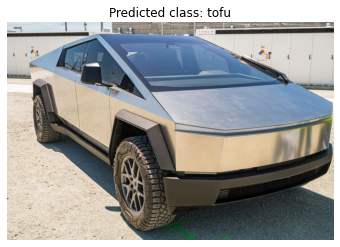

In [33]:
import random
image_path_test = random.choice(image_paths)
print(image_path_test)

from utils.misc import open_image
# image = open_image(image_path_test)
image = open_image("cybertruck.jpeg")

# image = Image.open("cybertruck.jpeg").convert("RGB")

# Get the image features
image_feature_dict = open_clip_compute_image_features_of_list([image])

# Get the zero shot classification
zero_shot_classification = open_clip_zero_shot_classification(image_feature_dict[0]["image_features"], text_features, class_names_and_other)

# Get the top 5 predictions
top_5 = sorted(zero_shot_classification.items(), key=lambda x: x[1], reverse=True)[:5]

# Plot the image with the predicted class
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis(False)
plt.title(f"Predicted class: {top_5[0][0]}") # if other in top_5, flag it as "other"
print(top_5)

In [34]:
# Pre-compute features of all images in list (to save computing on the fly, can then just do index-matching)
open_clip_image_features_list = open_clip_compute_image_features_of_list(image_paths=image_paths, device="cuda")

Computing OpenCLIP image features:   0%|          | 0/1392 [00:00<?, ?it/s]

In [35]:
from typing import List
from tqdm.auto import tqdm

def open_clip_get_image_and_text_similarity_dicts(image_paths: list,
                                                  target_classes: List[str]):
    
    # Set CLIP and BLIP to use GPU for creating image features if available
    # img_feature_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Encode text features on CPU (this is quick even for 100s of classes)
    # blip_text_features = blip_get_text_features(text=target_classes, device="cpu") # only get dims for zero-shot classification
    open_clip_text_features = open_clip_compute_text_features(text=target_classes)
    
    # Loop through image paths
    auto_created_labels = []
    for image_path in tqdm(image_paths, desc="Calculating image features and similarity dicts"):

        # Match image path to pre-computed image features
        # print(image_paths.index(image_path))
        open_clip_img_features = open_clip_image_features_list[image_paths.index(image_path)]["image_features"]
        # blip_img_features = blip_image_features_list[image_paths.index(image_path)]["image_features"][:, 0] # TODO: could the indexing be cleaner?
        
        # Get sorted similarity dicts
        open_clip_similarity_dict = open_clip_zero_shot_classification(open_clip_img_features, open_clip_text_features, target_classes, sorted=True)
        # blip_similarity_dict = blip_zero_shot_classification(blip_img_features, blip_text_features, target_classes, sorted=True)

        # # Average the values of the similarity dicts
        # avg_similarity_dict = {}
        # for key in open_clip_similarity_dict.keys():
        #     avg_similarity_dict[key] = (open_clip_similarity_dict[key] + blip_similarity_dict[key]) / 2
        
        # # Sort the average similarity dict and reduce length to 5
        # avg_similarity_dict = dict(list(sort_dict_by_values(avg_similarity_dict).items())[:5])

        # If the length of the similarity dicts is over 5, shorten to only get top 5
        if len(open_clip_similarity_dict) > 5:
            open_clip_similarity_dict = dict(list(open_clip_similarity_dict.items())[:5])
        
        # if len(blip_similarity_dict) > 5:
        #     blip_similarity_dict = dict(list(blip_similarity_dict.items())[:5])
        
        # Append to list
        auto_created_labels.append({"image_path": image_path,
                                    # "blip_sorted_similarity_dict": blip_similarity_dict,
                                    # "blip_top_1_class_name": list(blip_similarity_dict.keys())[0],
                                    # "blip_top_1_similarity_score": list(blip_similarity_dict.values())[0],
                                    "open_clip_sorted_similarity_dict": open_clip_similarity_dict,
                                    "open_clip_top_1_class_name": list(open_clip_similarity_dict.keys())[0],
                                    "open_clip_top_1_similarity_score": list(open_clip_similarity_dict.values())[0],
                                    # "avg_sorted_similarity_dict": avg_similarity_dict,
                                    # "avg_top_1_class_name": list(avg_similarity_dict.keys())[0],
                                    # "avg_top_1_similarity_score": list(avg_similarity_dict.values())[0]
                                })
    
    return auto_created_labels

In [52]:
class_names_and_other_and_not_food = class_names_and_other + ["not_food"] + ["non_edible"]
open_clip_zero_shot = open_clip_get_image_and_text_similarity_dicts(image_paths=all_paths, target_classes=class_names_and_other_and_not_food)


Calculating image features and similarity dicts:   0%|          | 0/1392 [00:00<?, ?it/s]

In [53]:
# Turn open_clip_zero_shot into a dataframe
open_clip_zero_shot_df = pd.DataFrame(open_clip_zero_shot)

# Add the class name to the dataframe
open_clip_zero_shot_df["true_label"] = open_clip_zero_shot_df["image_path"].apply(lambda x: str(x).split("/")[-2])

open_clip_zero_shot_df.head()

image_path  \
0  food_photos/cashews/96237783-2f60-4f2d-983a-f1...   
1  food_photos/cashews/3ab541fe-7b51-4382-acaa-98...   
2  food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da...   
3  food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b...   
4  food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f...   

                    open_clip_sorted_similarity_dict  \
0  {'cashews': 0.9854560494422913, 'nuts': 0.0145...   
1  {'cashews': 0.9960439205169678, 'nuts': 0.0039...   
2  {'cashews': 0.9985688924789429, 'nuts': 0.0014...   
3  {'cashews': 0.9954506754875183, 'nuts': 0.0045...   
4  {'cashews': 0.9988252520561218, 'nuts': 0.0011...   

  open_clip_top_1_class_name  open_clip_top_1_similarity_score true_label  
0                    cashews                          0.985456    cashews  
1                    cashews                          0.996044    cashews  
2                    cashews                          0.998569    cashews  
3                    cashews                          0.995451    cashews  
4                    cashews                          0.998825    cashews

In [54]:
# See if the top 1 class name matches the class name
open_clip_zero_shot_df["correct"] = open_clip_zero_shot_df["open_clip_top_1_class_name"] == open_clip_zero_shot_df["true_label"]

# How many correct?
open_clip_zero_shot_df["correct"].sum()

# What percentage correct?
open_clip_zero_shot_df["correct"].sum() / len(open_clip_zero_shot_df)

0.8512931034482759

In [48]:
# How many images have "other" in their open_clip_similarity_dict?
open_clip_zero_shot_df["open_clip_sorted_similarity_dict"].apply(lambda x: "other" in x.keys()).sum()

4

In [51]:
# How many images have "not_food" in their open_clip_similarity_dict?
open_clip_zero_shot_df["open_clip_sorted_similarity_dict"].apply(lambda x: "not_food" in x.keys()).sum()

43

In [58]:
# How many images have prediction "non_edible" as their top 1 prediction?
open_clip_zero_shot_df[open_clip_zero_shot_df["open_clip_top_1_class_name"].apply(lambda x: x == "non_edible")]

image_path  \
8   food_photos/not_food/IMG_5622 Large.jpeg   
9   food_photos/not_food/IMG_5577 Large.jpeg   
16  food_photos/not_food/IMG_5580 Large.jpeg   

                     open_clip_sorted_similarity_dict  \
8   {'non_edible': 0.3913979232311249, 'ham': 0.35...   
9   {'non_edible': 0.309169203042984, 'cream': 0.2...   
16  {'non_edible': 0.17790092527866364, 'cream': 0...   

   open_clip_top_1_class_name  open_clip_top_1_similarity_score true_label  \
8                  non_edible                          0.391398   not_food   
9                  non_edible                          0.309169   not_food   
16                 non_edible                          0.177901   not_food   

    correct  
8     False  
9     False  
16    False

In [40]:
# Show rows where the top 1 class name does not match the class name
open_clip_zero_shot_df[open_clip_zero_shot_df["correct"] == False]

image_path  \
6     food_photos/orange_juice/fa15a4e4-63b2-4491-88...   
7     food_photos/not_food/69829414631__3306DB5E-E8A...   
8              food_photos/not_food/IMG_5622 Large.jpeg   
9              food_photos/not_food/IMG_5577 Large.jpeg   
10             food_photos/not_food/IMG_5148 Large.jpeg   
...                                                 ...   
1382  food_photos/tea/1f46a92a-d5a5-468f-b982-6a4d23...   
1383  food_photos/tea/3108aa69-9a6a-44cc-b2e8-bd52d6...   
1385  food_photos/tea/b1e8a40f-ae3e-4b18-a45d-69c2a5...   
1386  food_photos/tea/20df8dbb-53c0-441e-910a-b69b08...   
1388  food_photos/ice_coffee/c1ab14a3-9ebe-418e-9724...   

                       open_clip_sorted_similarity_dict  \
6     {'fruit_juice': 0.502356767654419, 'orange_jui...   
7     {'chilli': 0.25515592098236084, 'cream': 0.175...   
8     {'ham': 0.5855583548545837, 'corn': 0.18715570...   
9     {'cream': 0.3223895728588104, 'mango': 0.22506...   
10    {'banana': 0.1890590637922287, 'cream': 0.0996...   
...                                                 ...   
1382  {'hot_chocolate': 0.5214517116546631, 'tea': 0...   
1383  {'hot_chocolate': 0.8795334100723267, 'coffee'...   
1385  {'shallots': 0.873421311378479, 'onion_red': 0...   
1386  {'hot_chocolate': 0.8618732690811157, 'coffee'...   
1388  {'maple_syrup': 0.3123567998409271, 'honey': 0...   

     open_clip_top_1_class_name  open_clip_top_1_similarity_score  \
6                   fruit_juice                          0.502357   
7                        chilli                          0.255156   
8                           ham                          0.585558   
9                         cream                          0.322390   
10                       banana                          0.189059   
...                         ...                               ...   
1382              hot_chocolate                          0.521452   
1383              hot_chocolate                          0.879533   
1385                   shallots                          0.873421   
1386              hot_chocolate                          0.861873   
1388                maple_syrup                          0.312357   

        true_label  correct  
6     orange_juice    False  
7         not_food    False  
8         not_food    False  
9         not_food    False  
10        not_food    False  
...            ...      ...  
1382           tea    False  
1383           tea    False  
1385           tea    False  
1386           tea    False  
1388    ice_coffee    False  

[207 rows x 6 columns]

In [37]:
# Find the value counts of the top 1 class name
open_clip_zero_shot_df["open_clip_top_1_class_name"].value_counts()

grapes_red         165
broccolini         155
pear               146
fennel             135
lychee             132
leek               132
parsley            126
corn               111
chilli             111
tomato              29
celery              15
onion_green         15
onion_white         11
banana               8
radish               5
cashews              5
cherries             4
brussel_sprouts      4
shallots             4
grapes_white         4
steak                4
potato_scallop       3
garlic               3
hot_chocolate        3
carrot               3
grapes_black         3
ice_coffee           3
nuts                 3
onion_brown          2
coriander            2
capsicum             2
red_wine             2
onion_red            2
milk                 2
fruit_smoothie       2
eggs                 2
prosciutto           1
tea                  1
guava                1
green_beans          1
cauliflower          1
fruit_juice          1
maple_syrup          1
biltong    

In [39]:
wrong_preds_new = open_clip_zero_shot_df[open_clip_zero_shot_df["open_clip_top_1_class_name"] != open_clip_zero_shot_df["true_label"]][["image_path", "true_label", "open_clip_top_1_class_name", "open_clip_top_1_similarity_score", "open_clip_sorted_similarity_dict"]]
wrong_preds_new

image_path    true_label  \
6     food_photos/orange_juice/fa15a4e4-63b2-4491-88...  orange_juice   
182   food_photos/steak/453c3d46-0412-4567-a070-ef97...         steak   
189   food_photos/lychee/e87a9984-5455-4efc-9f28-d35...        lychee   
191   food_photos/lychee/20519ff4-8ecf-4126-a514-947...        lychee   
200   food_photos/lychee/6d49671c-e25a-45c9-acea-9b0...        lychee   
...                                                 ...           ...   
1371  food_photos/tea/1f46a92a-d5a5-468f-b982-6a4d23...           tea   
1372  food_photos/tea/3108aa69-9a6a-44cc-b2e8-bd52d6...           tea   
1374  food_photos/tea/b1e8a40f-ae3e-4b18-a45d-69c2a5...           tea   
1375  food_photos/tea/20df8dbb-53c0-441e-910a-b69b08...           tea   
1377  food_photos/ice_coffee/c1ab14a3-9ebe-418e-9724...    ice_coffee   

     open_clip_top_1_class_name  open_clip_top_1_similarity_score  \
6                   fruit_juice                          0.502357   
182                 chimichurri                          0.928270   
189                      chilli                          0.118791   
191                 onion_white                          0.668997   
200                      chilli                          0.131570   
...                         ...                               ...   
1371              hot_chocolate                          0.521567   
1372              hot_chocolate                          0.879604   
1374                   shallots                          0.873423   
1375              hot_chocolate                          0.861901   
1377                maple_syrup                          0.312469   

                       open_clip_sorted_similarity_dict  
6     {'fruit_juice': 0.5023571848869324, 'orange_ju...  
182   {'chimichurri': 0.9282695055007935, 'steak': 0...  
189   {'chilli': 0.1187906265258789, 'potato_brown':...  
191   {'onion_white': 0.6689971685409546, 'mandarin'...  
200   {'chilli': 0.13156960904598236, 'lychee': 0.11...  
...                                                 ...  
1371  {'hot_chocolate': 0.5215670466423035, 'tea': 0...  
1372  {'hot_chocolate': 0.8796043992042542, 'coffee'...  
1374  {'shallots': 0.8734229207038879, 'onion_red': ...  
1375  {'hot_chocolate': 0.8619011640548706, 'coffee'...  
1377  {'maple_syrup': 0.3124692738056183, 'honey': 0...  

[196 rows x 5 columns]

In [40]:
# Get the top 100 most wrong examples
most_wrong = wrong_preds_new.sort_values("open_clip_top_1_similarity_score", ascending=False)[:100]
most_wrong

image_path   true_label  \
416  food_photos/onion_green/c5fd3879-ef0a-454b-a5e...  onion_green   
378  food_photos/onion_green/62f79504-b4b6-420b-970...  onion_green   
397  food_photos/onion_green/0933d5c6-33b8-46f9-a77...  onion_green   
487  food_photos/corn/803b56ae-9b15-4e71-8074-e6406...         corn   
389  food_photos/onion_green/e68eee55-b64e-4c3f-909...  onion_green   
..                                                 ...          ...   
428  food_photos/onion_green/a4c1e890-cafd-47ac-a2e...  onion_green   
364  food_photos/onion_green/18016225-a55d-4448-896...  onion_green   
421  food_photos/onion_green/4c5c896d-6b6a-4201-aad...  onion_green   
448  food_photos/onion_green/9711c089-03e2-48c2-a1d...  onion_green   
472  food_photos/onion_green/22045ab6-cc80-49fd-b05...  onion_green   

    open_clip_top_1_class_name  open_clip_top_1_similarity_score  \
416                       leek                          0.993060   
378                       leek                          0.992639   
397                       leek                          0.991639   
487                       leek                          0.991277   
389                       leek                          0.991095   
..                         ...                               ...   
428                       leek                          0.789351   
364                       leek                          0.778793   
421                       leek                          0.777086   
448                       leek                          0.775355   
472                       leek                          0.775094   

                      open_clip_sorted_similarity_dict  
416  {'leek': 0.9930599927902222, 'onion_green': 0....  
378  {'leek': 0.9926387071609497, 'onion_green': 0....  
397  {'leek': 0.9916391968727112, 'onion_green': 0....  
487  {'leek': 0.9912769794464111, 'corn': 0.0023446...  
389  {'leek': 0.9910954236984253, 'celery': 0.00386...  
..                                                 ...  
428  {'leek': 0.7893514633178711, 'onion_green': 0....  
364  {'leek': 0.7787929177284241, 'onion_green': 0....  
421  {'leek': 0.7770860195159912, 'onion_green': 0....  
448  {'leek': 0.7753552794456482, 'onion_green': 0....  
472  {'leek': 0.7750938534736633, 'onion_green': 0....  

[100 rows x 5 columns]

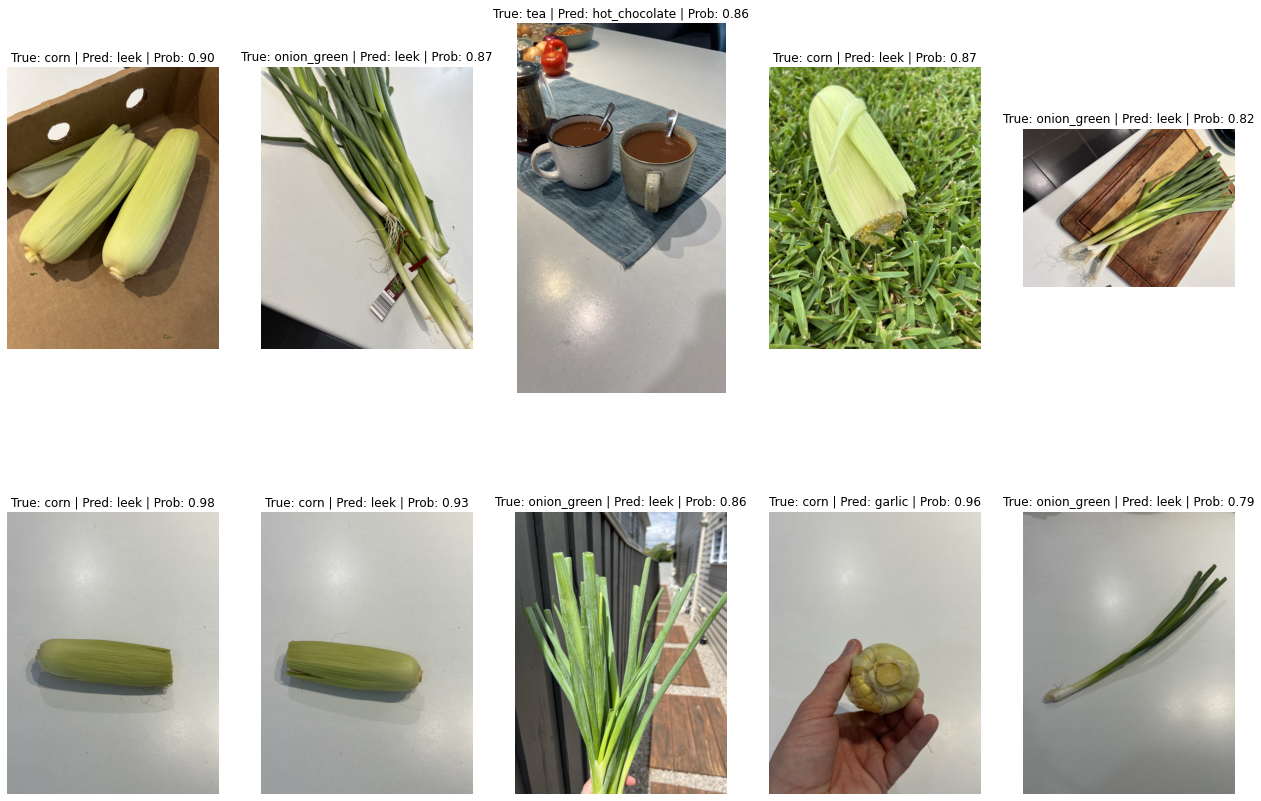

In [58]:
# Plot 10 random examples from most_wrong
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(22, 15))

# Get 10 random indices
random_indices = np.random.choice(range(len(most_wrong)), size=10, replace=False)

for i in range(10):
    ax[i // 5, i % 5].imshow(plt.imread(most_wrong["image_path"].iloc[random_indices[i]]))
    ax[i // 5, i % 5].set_title(f"True: {most_wrong['true_label'].iloc[random_indices[i]]} | Pred: {most_wrong['open_clip_top_1_class_name'].iloc[random_indices[i]]} | Prob: {most_wrong['open_clip_top_1_similarity_score'].iloc[random_indices[i]]:.2f}")
    ax[i // 5, i % 5].axis(False)


In [3]:
# Next:
# Create functions for zero-shot classifiers
# Go through all the paths apply the zero-shot classifiers
# Add some images which are examples which should be food/not food etc
# The model should pick these up...
# Create labels for the images based on the results of the zero-shot classifiers

In [44]:
import torch
from lavis.models import load_model_and_preprocess
from PIL import Image

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: move to utils.py?
def open_image(image_path_or_PIL):
    try:
        return Image.open(image_path_or_PIL).convert("RGB")
    except:
        return image_path_or_PIL.convert("RGB")

misc_dict = {"chicken": 123,
             "pizza": 456,
             "hot dog": 789}

# TODO: move to utils.py
# Create a function to sort dict by values
def sort_dict_by_values(dict_to_sort):
    sorted_dict = dict(sorted(dict_to_sort.items(), key=lambda x:x[1], reverse=True))
    return sorted_dict
    # return {k: v for k, v in sorted(dict_to_sort.items(), key=lambda item: item[1], reverse=True)}

sort_dict_by_values(misc_dict)

#### BLIP ####

# Start Vision-Language modelling section
blip_feature_extractor_model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_feature_extractor", 
                                                                                         model_type="base", 
                                                                                         is_eval=True, 
                                                                                         device=device)

def blip_get_image_features(image,
                            model=blip_feature_extractor_model, 
                            vis_processors=vis_processors, 
                            device=device,
                            low_dim=True):

    # Make sure model and image are on the same device
    blip_feature_extractor_model.to(device)
                 
    # Preprocess image
    image = vis_processors["eval"](image).unsqueeze(0).to(device)

    # Turn image into sample dict
    sample = {"image": image}

    # Get features
    features_image = model.extract_features(sample, mode="image")

    # Turn features into low-dim
    if low_dim:
        features_image = features_image.image_embeds_proj
    else:
        features_image = features_image.image_embeds

    return features_image

def blip_get_text_features(text: list,
                           model=blip_feature_extractor_model, 
                           txt_processors=txt_processors, 
                           device=device,
                           low_dim=True):
                 
    # Preprocess image
    text_input = [txt_processors["eval"](text) for text in text]

    # Turn image into sample dict
    sample = {"text_input": text_input}

    # Get features
    features_text = model.extract_features(sample, mode="text")

    # Turn features into low-dim
    if low_dim:
        features_text = features_text.text_embeds_proj[:, 0]
    else:
        features_text = features_text.text_embeds[:, 0]

    return features_text.to(device)


### CLIP

### Load CLIP model and create helper functions
clip_feature_extractor_model, clip_vis_processors, clip_txt_processors = load_model_and_preprocess(name="clip_feature_extractor", 
                                                                                                   model_type="ViT-B-16", 
                                                                                                   is_eval=True, 
                                                                                                   device=device)

# Create a function to get CLIP image features
def clip_get_image_features(image, 
                            clip_feature_extractor_model=clip_feature_extractor_model, 
                            clip_vis_processors=clip_vis_processors, 
                            device=device):
    processed_image = clip_vis_processors["eval"](image).unsqueeze(0).to(device)
    sample = {"image": processed_image}
    clip_image_features = clip_feature_extractor_model.extract_features(sample)
    # clip_image_features = clip_features.image_embeds_proj
    return clip_image_features

def clip_get_text_features(text,  clip_feature_extractor_model=clip_feature_extractor_model, clip_txt_processors=clip_txt_processors, device=device):
    text_input = clip_txt_processors["eval"](text)
    sample = {"text_input": [text_input]}
    features_text = clip_feature_extractor_model.extract_features(sample)
    return features_text

# Create a function to get CLIP image features
def clip_get_image_features(image, 
                            clip_feature_extractor_model=clip_feature_extractor_model, 
                            clip_vis_processors=clip_vis_processors, 
                            device=device):
    processed_image = clip_vis_processors["eval"](image).unsqueeze(0).to(device)
    sample = {"image": processed_image}
    clip_image_features = clip_feature_extractor_model.extract_features(sample)
    # clip_image_features = clip_features.image_embeds_proj
    return clip_image_features

def clip_get_text_features(text:list,
                           model=clip_feature_extractor_model,
                           clip_txt_processors=clip_txt_processors,
                           device=device):
    text_input = [clip_txt_processors["eval"](text) for text in text]
    features = model.extract_features({"text_input": text_input})
    return features.to(device)



In [45]:
def blip_zero_shot_classification(image_features, text_features, class_names, blip_model=blip_feature_extractor_model, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    similarity_values = (image_features @ text_features.t())[0] / blip_model.temp
    probabilities = torch.softmax(similarity_values, dim=0).cpu().tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict


def clip_zero_shot_classification(image_features, text_features, class_names, clip_model=clip_feature_extractor_model, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    similarity_values = (image_features @ text_features.T)[0] / 0.01
    probabilities = torch.softmax(similarity_values, dim=0).cpu().tolist() # return values to CPU

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict

### OpenCLIP helper functions

In [26]:
import torch
from PIL import Image
import open_clip
from tqdm.auto import tqdm

open_clip_model_name = "ViT-H-14"
open_clip_pretrained = 'laion2b_s32b_b79k' 

open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms(open_clip_model_name, pretrained=open_clip_pretrained)
open_clip_tokenizer = open_clip.get_tokenizer(open_clip_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
open_clip_model.to(device);

def open_clip_compute_image_features_of_list(image_paths: list,
                                             open_clip_model=open_clip_model,
                                             open_clip_preprocess=open_clip_preprocess,
                                             device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing OpenCLIP image features"):
        image_feature_dict = {}

        image = open_clip_preprocess(Image.open(image_path)).unsqueeze(0)

        with torch.no_grad(), torch.cuda.amp.autocast():
            open_clip_model.to(device)
            image_features = open_clip_model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)       

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def open_clip_get_text_features(text: list,
                                    open_clip_model=open_clip_model,
                                    open_clip_tokenizer=open_clip_tokenizer,
                                    device=device):

    text = open_clip_tokenizer(text)
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        open_clip_model.to(device)
        text_features = open_clip_model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    return text_features

def open_clip_zero_shot_classification(image_features, text_features, class_names, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        similarity_values = (image_features @ text_features.T)[0] / 0.01
        probabilities = torch.softmax(similarity_values, dim=-1).cpu().tolist() # return values to CPU

        # Create a dict of class names and their probabilities
        class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict

## Create lists of binary classifiers for sorting images

In [47]:
food_not_food = ["edible_food", "other"]
logo_not_logo = ["contains_logo", "other"]

In [48]:
# Create BLIP and CLIP features for binary classifiers
blip_food_not_food_features = blip_get_text_features(text=food_not_food, device="cpu")
clip_food_not_food_features = clip_get_text_features(text=food_not_food, device="cpu")
open_clip_food_not_food_features = open_clip_get_text_features(text=food_not_food, device="cpu")

# blip_logo_not_logo_features = blip_get_text_features_of_list(target_list=logo_not_logo, device="cpu")
# clip_logo_not_logo_features = clip_get_text_features_of_list(target_list=logo_not_logo, device="cpu")

In [49]:
blip_food_not_food_features.shape, clip_food_not_food_features.shape, open_clip_food_not_food_features.shape 

(torch.Size([2, 256]), torch.Size([2, 512]), torch.Size([2, 1024]))

In [50]:
blip_get_text_features(text=["pizza", "hot dog", "chicken"], device="cpu").shape

torch.Size([3, 256])

Now let's open each of the images and compute their zero-shot classification details.

In [51]:
def clip_compute_image_features_of_list(image_paths: list,
                                        device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing CLIP image features"):
        image_feature_dict = {}
        image = open_image(image_path)
        image_features = clip_get_image_features(image=image, device=device).to("cpu")

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def blip_compute_image_features_of_list(image_paths: list,
                                        device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing BLIP image features"):
        image_feature_dict = {}
        image = open_image(image_path)
        image_features = blip_get_image_features(image=image, device=device)

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features.cpu() # store image features on CPU to prevent extra memory usage
        image_features_list.append(image_feature_dict)
    
    return image_features_list

### Precompute image features for use later 

Computing image features takes the longest time so compute these first and save them for later.

In [52]:
blip_image_features_list = blip_compute_image_features_of_list(image_paths=all_paths, device="cuda")
# clip_image_features_list = clip_compute_image_features_of_list(image_paths=all_paths, device="cuda") # this results in out of memory errors (the GELU function in OpenAI clip is busted)
open_clip_image_features_list = open_clip_compute_image_features_of_list(image_paths=all_paths, device="cuda")

Computing BLIP image features:   0%|          | 0/1381 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1381 [00:00<?, ?it/s]

In [53]:
blip_image_features_list[0]["image_features"].shape
blip_image_features_list[0]["image_features"][:, 0].shape

torch.Size([1, 256])

In [54]:
from typing import List

def get_image_and_text_similarity_dicts(image_paths: list,
                                        target_classes: List[str],):
    
    # Set CLIP and BLIP to use GPU for creating image features if available
    img_feature_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Encode text features on CPU (this is quick even for 100s of classes)
    blip_text_features = blip_get_text_features(text=target_classes, device="cpu") # only get dims for zero-shot classification
    open_clip_text_features = open_clip_get_text_features(text=target_classes, device="cpu")
    
    # Loop through image paths
    auto_created_labels = []
    for image_path in tqdm(image_paths, desc="Calculating image features and similarity dicts"):

        # Match image path to pre-computed image features
        # print(image_paths.index(image_path))
        open_clip_img_features = open_clip_image_features_list[image_paths.index(image_path)]["image_features"]
        blip_img_features = blip_image_features_list[image_paths.index(image_path)]["image_features"][:, 0] # TODO: could the indexing be cleaner?
        
        # Get sorted similarity dicts
        open_clip_similarity_dict = open_clip_zero_shot_classification(open_clip_img_features, open_clip_text_features, target_classes, sorted=True)
        blip_similarity_dict = blip_zero_shot_classification(blip_img_features, blip_text_features, target_classes, sorted=True)

        # Average the values of the similarity dicts
        avg_similarity_dict = {}
        for key in open_clip_similarity_dict.keys():
            avg_similarity_dict[key] = (open_clip_similarity_dict[key] + blip_similarity_dict[key]) / 2
        
        # Sort the average similarity dict and reduce length to 5
        avg_similarity_dict = dict(list(sort_dict_by_values(avg_similarity_dict).items())[:5])

        # If the length of the similarity dicts is over 5, shorten to only get top 5
        if len(open_clip_similarity_dict) > 5:
            open_clip_similarity_dict = dict(list(open_clip_similarity_dict.items())[:5])
        
        if len(blip_similarity_dict) > 5:
            blip_similarity_dict = dict(list(blip_similarity_dict.items())[:5])
        
        # Append to list
        auto_created_labels.append({"image_path": image_path,
                                    "blip_sorted_similarity_dict": blip_similarity_dict,
                                    "blip_top_1_class_name": list(blip_similarity_dict.keys())[0],
                                    "blip_top_1_similarity_score": list(blip_similarity_dict.values())[0],
                                    "open_clip_sorted_similarity_dict": open_clip_similarity_dict,
                                    "open_clip_top_1_class_name": list(open_clip_similarity_dict.keys())[0],
                                    "open_clip_top_1_similarity_score": list(open_clip_similarity_dict.values())[0],
                                    "avg_sorted_similarity_dict": avg_similarity_dict,
                                    "avg_top_1_class_name": list(avg_similarity_dict.keys())[0],
                                    "avg_top_1_similarity_score": list(avg_similarity_dict.values())[0]})
    
    return auto_created_labels

In [55]:
# target_classes = ["logo", "no_logo"]
food_labels = sorted(list(set([p.parent.name for p in all_paths])))
food_labels.append("other")

print(food_labels)
       
target_classes = food_labels
zero_shot_labels = get_image_and_text_similarity_dicts(image_paths=all_paths,
                                                       target_classes=target_classes)

['banana', 'biltong', 'blueberries', 'broccolini', 'brussel_sprouts', 'cashews', 'cauliflower', 'celery', 'cherries', 'chilli', 'coriander', 'corn', 'cucumber', 'fennel', 'fruit_smoothie', 'garlic', 'grapes_black', 'grapes_red', 'grapes_white', 'green_beans', 'ice_coffee', 'lemon', 'lychee', 'milk', 'omelette', 'onion_green', 'orange_juice', 'parsley', 'pear', 'prosciutto', 'radish', 'red_wine', 'salami', 'steak', 'sushi', 'tea', 'tomato', 'yoghurt', 'other']


Calculating image features and similarity dicts:   0%|          | 0/1381 [00:00<?, ?it/s]

In [56]:
zero_shot_labels[0]

{'image_path': PosixPath('food_photos/cashews/96237783-2f60-4f2d-983a-f1b289067887.jpeg'),
 'blip_sorted_similarity_dict': {'cashews': 0.9995593428611755,
  'brussel_sprouts': 0.00015514050028286874,
  'green_beans': 0.0001156708094640635,
  'garlic': 0.00010966416448354721,
  'corn': 1.4903539522492792e-05},
 'blip_top_1_class_name': 'cashews',
 'blip_top_1_similarity_score': 0.9995593428611755,
 'open_clip_sorted_similarity_dict': {'cashews': 0.9999990463256836,
  'chilli': 2.4579918544986867e-07,
  'garlic': 2.102431864159371e-07,
  'corn': 1.7983053623993328e-07,
  'banana': 1.1610730865641017e-07},
 'open_clip_top_1_class_name': 'cashews',
 'open_clip_top_1_similarity_score': 0.9999990463256836,
 'avg_sorted_similarity_dict': {'cashews': 0.9997791945934296,
  'brussel_sprouts': 7.761913622417183e-05,
  'green_beans': 5.783836359540828e-05,
  'garlic': 5.4937203834981574e-05,
  'corn': 7.541685029366363e-06},
 'avg_top_1_class_name': 'cashews',
 'avg_top_1_similarity_score': 0.9997

In [57]:
# Turn list of dicts into a dataframe
zero_shot_labels_df = pd.DataFrame(zero_shot_labels)
zero_shot_labels_df["true_label"] = zero_shot_labels_df["image_path"].apply(lambda x: str(x).split("/")[-2])
zero_shot_labels_df.head()

image_path  \
0  food_photos/cashews/96237783-2f60-4f2d-983a-f1...   
1  food_photos/cashews/3ab541fe-7b51-4382-acaa-98...   
2  food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da...   
3  food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b...   
4  food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f...   

                         blip_sorted_similarity_dict blip_top_1_class_name  \
0  {'cashews': 0.9995593428611755, 'brussel_sprou...               cashews   
1  {'cashews': 0.9996260404586792, 'green_beans':...               cashews   
2  {'cashews': 0.9977321624755859, 'green_beans':...               cashews   
3  {'cashews': 0.9999206066131592, 'green_beans':...               cashews   
4  {'cashews': 0.9990397095680237, 'corn': 0.0003...               cashews   

   blip_top_1_similarity_score  \
0                     0.999559   
1                     0.999626   
2                     0.997732   
3                     0.999921   
4                     0.999040   

                    open_clip_sorted_similarity_dict  \
0  {'cashews': 0.9999990463256836, 'chilli': 2.45...   
1  {'cashews': 0.9999997615814209, 'corn': 7.9799...   
2  {'cashews': 0.9999998807907104, 'corn': 1.0087...   
3  {'cashews': 0.9999994039535522, 'corn': 2.1691...   
4  {'cashews': 0.9999997615814209, 'corn': 7.2658...   

  open_clip_top_1_class_name  open_clip_top_1_similarity_score  \
0                    cashews                          0.999999   
1                    cashews                          1.000000   
2                    cashews                          1.000000   
3                    cashews                          0.999999   
4                    cashews                          1.000000   

                          avg_sorted_similarity_dict avg_top_1_class_name  \
0  {'cashews': 0.9997791945934296, 'brussel_sprou...              cashews   
1  {'cashews': 0.99981290102005, 'green_beans': 7...              cashews   
2  {'cashews': 0.9988660216331482, 'green_beans':...              cashews   
3  {'cashews': 0.9999600052833557, 'green_beans':...              cashews   
4  {'cashews': 0.9995197355747223, 'corn': 0.0001...              cashews   

   avg_top_1_similarity_score true_label  
0                    0.999779    cashews  
1                    0.999813    cashews  
2                    0.998866    cashews  
3                    0.999960    cashews  
4                    0.999520    cashews

In [58]:
zero_shot_labels_df["avg_top_1_similarity_score"].mean()

0.7802769172720074

In [59]:
# How many CLIP top-1 similarity scores are above 0.95?
len(zero_shot_labels_df[zero_shot_labels_df["avg_top_1_similarity_score"] > 0.95])

382

In [60]:
# Get the accuracy of blip_top_1 compared to true_label
blip_top_1_accuracy = (zero_shot_labels_df["blip_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)
open_clip_top_1_accuracy = (zero_shot_labels_df["open_clip_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)
avg_top_1_accuracy = (zero_shot_labels_df["avg_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)

# Print the top 1 accuracy values
print(f"BLIP top 1 accuracy: {blip_top_1_accuracy}")
print(f"Open-Clip top 1 accuracy: {open_clip_top_1_accuracy}")
print(f"Avg top 1 accuracy: {avg_top_1_accuracy}")

BLIP top 1 accuracy: 0.7154236060825488
Open-Clip top 1 accuracy: 0.9695872556118754
Avg top 1 accuracy: 0.9514844315713251


In [62]:
# Show samples where the top 1 class name is not the true label
wrong_preds = zero_shot_labels_df[zero_shot_labels_df["avg_top_1_class_name"] != zero_shot_labels_df["true_label"]][["image_path", "true_label", "avg_top_1_class_name", "avg_sorted_similarity_dict"]]
wrong_preds.head(10)

image_path true_label  \
189  food_photos/lychee/e87a9984-5455-4efc-9f28-d35...     lychee   
191  food_photos/lychee/20519ff4-8ecf-4126-a514-947...     lychee   
200  food_photos/lychee/6d49671c-e25a-45c9-acea-9b0...     lychee   
205  food_photos/lychee/9dd6daf8-d4f2-452a-bb07-6d9...     lychee   
214  food_photos/lychee/3512d87a-dbc6-4dc5-9e71-d94...     lychee   
217  food_photos/lychee/a52284a9-8884-45d1-9e9c-ad0...     lychee   
235  food_photos/lychee/7d649970-2683-4a04-810f-08a...     lychee   
236  food_photos/lychee/e8da2a34-b0cb-479d-b4d9-d11...     lychee   
247  food_photos/lychee/f9299d77-4fca-4c1b-8217-61d...     lychee   
251  food_photos/lychee/cc90ac93-9394-42af-8f10-84d...     lychee   

    avg_top_1_class_name                         avg_sorted_similarity_dict  
189               chilli  {'chilli': 0.301347856875509, 'tomato': 0.2453...  
191                lemon  {'lemon': 0.26645274460315704, 'onion_green': ...  
200               chilli  {'chilli': 0.2198713067919016, 'lychee': 0.207...  
205               chilli  {'chilli': 0.2754208566620946, 'tomato': 0.222...  
214                lemon  {'lemon': 0.24421336501836777, 'garlic': 0.151...  
217               garlic  {'garlic': 0.20151639729738235, 'lemon': 0.163...  
235                lemon  {'lemon': 0.23603316023945808, 'onion_green': ...  
236               tomato  {'tomato': 0.343158520758152, 'lychee': 0.2685...  
247          onion_green  {'onion_green': 0.3108229311183095, 'garlic': ...  
251               tomato  {'tomato': 0.3667212426662445, 'lychee': 0.238...

In [ ]:
wrong_preds

In [63]:
len(wrong_preds) 

67

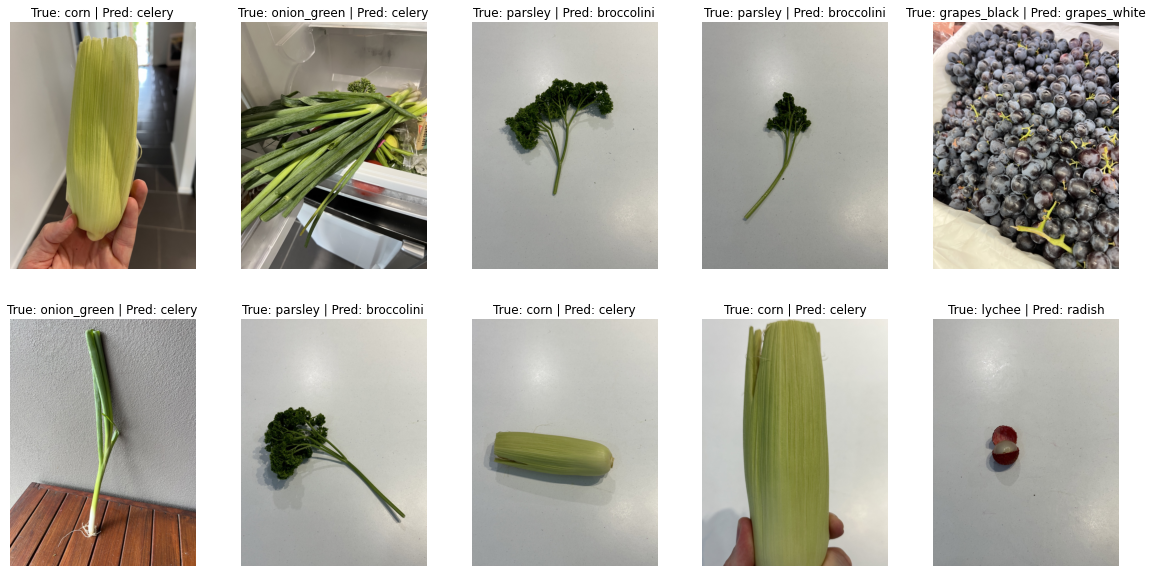

In [22]:
# Plot 10 random samples where the top 1 class name is not the true label
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, row in enumerate(wrong_preds.sample(10).iterrows()):
    # print(row)
    row = row[1]
    # print(row)
    img = Image.open(row["image_path"])
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].set_title(f"True: {row['true_label']} | Pred: {row['avg_top_1_class_name']}")
    ax[i//5, i%5].axis("off")

In [23]:
# Get zero-shot classification for logo/no logo
logo_no_logo_zero_shot_labels = get_image_and_text_similarity_dicts(image_paths=all_paths,
                                                                    target_classes=["logo", "no_logo"])

Calculating image features and similarity dicts:   0%|          | 0/1381 [00:00<?, ?it/s]

In [24]:
# Turn list of dicts into a dataframe
logo_not_logo_df = pd.DataFrame(logo_no_logo_zero_shot_labels)
logo_not_logo_df

image_path  \
0     food_photos/cashews/96237783-2f60-4f2d-983a-f1...   
1     food_photos/cashews/3ab541fe-7b51-4382-acaa-98...   
2     food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da...   
3     food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b...   
4     food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f...   
...                                                 ...   
1376  food_photos/prosciutto/3adcda2f-6bc0-495a-ae37...   
1377  food_photos/ice_coffee/c1ab14a3-9ebe-418e-9724...   
1378  food_photos/ice_coffee/f127961a-5444-4041-b0fd...   
1379  food_photos/ice_coffee/1e3ead6d-71fe-4ebf-af09...   
1380  food_photos/ice_coffee/69fe431a-00d3-4d09-aebb...   

                            blip_sorted_similarity_dict blip_top_1_class_name  \
0     {'no_logo': 0.8490176796913147, 'logo': 0.1509...               no_logo   
1     {'no_logo': 0.5557100176811218, 'logo': 0.4442...               no_logo   
2     {'no_logo': 0.5084973573684692, 'logo': 0.4915...               no_logo   
3     {'no_logo': 0.72601717710495, 'logo': 0.273982...               no_logo   
4     {'no_logo': 0.7572483420372009, 'logo': 0.2427...               no_logo   
...                                                 ...                   ...   
1376  {'logo': 0.5026812553405762, 'no_logo': 0.4973...                  logo   
1377  {'logo': 0.6477257609367371, 'no_logo': 0.3522...                  logo   
1378  {'logo': 0.7617493867874146, 'no_logo': 0.2382...                  logo   
1379  {'no_logo': 0.5146018266677856, 'logo': 0.4853...               no_logo   
1380  {'no_logo': 0.6591877341270447, 'logo': 0.3408...               no_logo   

      blip_top_1_similarity_score  \
0                        0.849018   
1                        0.555710   
2                        0.508497   
3                        0.726017   
4                        0.757248   
...                           ...   
1376                     0.502681   
1377                     0.647726   
1378                     0.761749   
1379                     0.514602   
1380                     0.659188   

                       open_clip_sorted_similarity_dict  \
0     {'no_logo': 0.8233283758163452, 'logo': 0.1766...   
1     {'no_logo': 0.8539127111434937, 'logo': 0.1460...   
2     {'logo': 0.7704647779464722, 'no_logo': 0.2295...   
3     {'no_logo': 0.7606506943702698, 'logo': 0.2393...   
4     {'no_logo': 0.8807970285415649, 'logo': 0.1192...   
...                                                 ...   
1376  {'no_logo': 0.9343951344490051, 'logo': 0.0656...   
1377  {'no_logo': 0.8774768114089966, 'logo': 0.1225...   
1378  {'no_logo': 0.9736446738243103, 'logo': 0.0263...   
1379  {'no_logo': 0.9886682629585266, 'logo': 0.0113...   
1380  {'no_logo': 0.9910145401954651, 'logo': 0.0089...   

     open_clip_top_1_class_name  open_clip_top_1_similarity_score  \
0                       no_logo                          0.823328   
1                       no_logo                          0.853913   
2                          logo                          0.770465   
3                       no_logo                          0.760651   
4                       no_logo                          0.880797   
...                         ...                               ...   
1376                    no_logo                          0.934395   
1377                    no_logo                          0.877477   
1378                    no_logo                          0.973645   
1379                    no_logo                          0.988668   
1380                    no_logo                          0.991015   

                             avg_sorted_similarity_dict avg_top_1_class_name  \
0     {'no_logo': 0.83617302775383, 'logo': 0.163826...              no_logo   
1     {'no_logo': 0.7048113644123077, 'logo': 0.2951...              no_logo   
2     {'logo': 0.6309836953878403, 'no_logo': 0.3690...                 logo   
3     {'no_logo': 0.7433339357376099, 'logo': 0.2566...     

<AxesSubplot:>

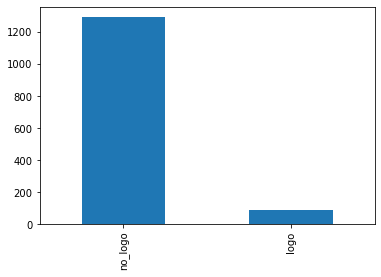

In [25]:
logo_not_logo_df.avg_top_1_class_name.value_counts().plot(kind="bar")

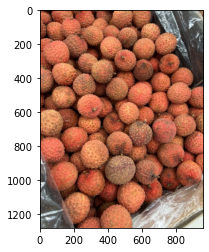

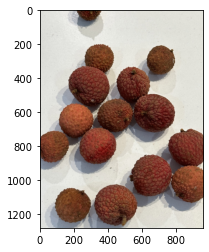

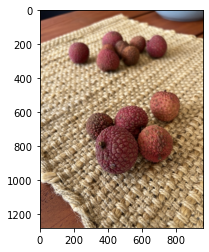

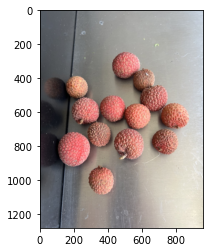

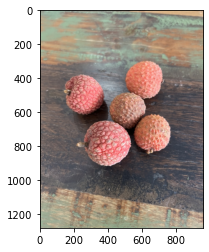

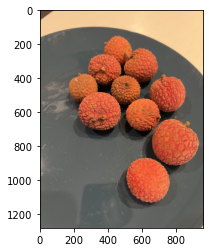

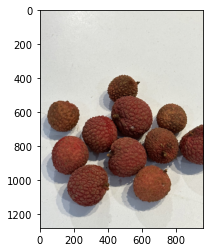

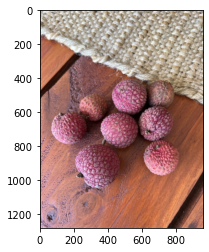

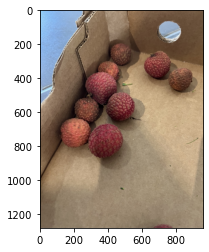

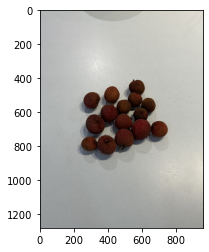

In [26]:
# Plot 10 random images where blip_top_1_class_name == "logo"
logo_samples = logo_not_logo_df[logo_not_logo_df["avg_top_1_class_name"] == "logo"].sample(10)

# Plot 10 images from the logo samples
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for row in logo_samples.iterrows():
    img = mpimg.imread(row[1]["image_path"])
    imgplot = plt.imshow(img)
    plt.show()

## Practice BLIP zero-shot on a single image

See the source: https://github.com/salesforce/LAVIS/blob/main/examples/blip_zero_shot_classification.ipynb

In [27]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
model, vis_processors, _ = load_model_and_preprocess("blip_feature_extractor", model_type="base", is_eval=True, device=device)

In [29]:
cls_names = ["edible_food", "other"]

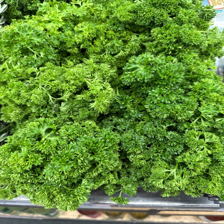

In [30]:
# Open a random image from all_paths
import random
image_path = random.choice(all_paths)
raw_image = Image.open(image_path).convert("RGB")
display(raw_image.resize((224, 224)))

In [31]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
image_features = model.extract_features({"image": image}, mode="image").image_embeds_proj[:, 0]

In [32]:
def blip_get_text_features_for_zero_shot_classification(text:list,
                                                        model=blip_feature_extractor_model):
    text_features = model.extract_features({"text_input": text}, mode="text").text_embeds_proj[:, 0]
    return text_features

text_features = blip_get_text_features_for_zero_shot_classification(["food", "not_food"])
text_features.shape

torch.Size([2, 256])

In [33]:
def blip_zero_shot_classification(image_features, text_features, class_names, blip_model=blip_feature_extractor_model):
    similarity_values = (image_features @ text_features.T)[0] / blip_model.temp
    probabilities = torch.softmax(similarity_values, dim=0).tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    return class_name_similarity_probability_dict

## Practice CLIP zero-shot on a single image

In [34]:
clip_feature_extractor_model, clip_vis_processors, clip_txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-L-14", is_eval=True, device=device)

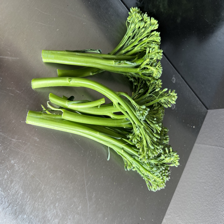

In [35]:
# Open a random image from all_paths
import random
image_path = random.choice(all_paths)
raw_image = Image.open(image_path).convert("RGB")
display(raw_image.resize((224, 224)))

In [36]:
# Process image
image = clip_vis_processors["eval"](raw_image).unsqueeze(0).to(device)
clip_image_features = clip_feature_extractor_model.extract_features({"image": image})
clip_image_features.shape

torch.Size([1, 768])

In [37]:
def clip_get_text_features_for_zero_shot_classification(text:list,
                                                        model=clip_feature_extractor_model):
    features = model.extract_features({"text_input": text})
    return features

class_names = ["edible_food", "other"]
clip_text_features = clip_get_text_features_for_zero_shot_classification(class_names)
clip_text_features.shape

torch.Size([2, 768])

In [38]:
def clip_zero_shot_classification(image_features, text_features, class_names, clip_model=clip_feature_extractor_model):
    similarity_values = (image_features @ text_features.T)[0] / 0.01
    probabilities = torch.softmax(similarity_values, dim=0).tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    return class_name_similarity_probability_dict

In [39]:
clip_zero_shot_classification(clip_image_features, clip_text_features, class_names)

{'edible_food': 1.0, 'other': 0.0}

## Try OpenCLIP for zero-shot classification

See: https://github.com/mlfoundations/open_clip 

And a notebook example: https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_clip.ipynb 

In [46]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32-quickgelu', 'openai'),
 ('ViT-B-32-quickgelu', 'laion400m_e31'),
 ('ViT-B-32-quickgelu', 'laion400m_e32'),
 ('ViT-B-16', 'openai'),
 ('ViT-B-16', 'laion400m_e31'),
 ('ViT-B-16', 'laion400m_e32'),
 ('ViT-B-16', 'laion2b_s34b_b88k'),
 ('ViT-B-16-plus-240', 'laion400m_e31'),
 ('ViT-B-16-plus-240', 'laion400m_e32'),
 ('ViT-L-14', 'openai'),
 ('ViT-L-14', 'laion400m_e31'),
 ('ViT-L-14', 'laion400m_e32'),
 ('ViT-L-14', 'laion2b_s32b_b82k'),
 ('ViT-L-14-336', 'openai'),
 ('ViT-H-14', 'laion2b_s32b_

In [66]:
import torch
from PIL import Image
import open_clip
from tqdm.auto import tqdm

open_clip_model_name = "ViT-H-14"
open_clip_pretrained = "laion2b_s32b_b79k"

# open_clip_model_name = 'convnext_large_d' 
# open_clip_pretrained = 'laion2b_s26b_b102k_augreg'

# open_clip_model_name = 'ViT-g-14'
# open_clip_pretrained = 'laion2b_s12b_b42k'

def create_open_clip_model_and_preprocess(model_name: str, pretrained: str, device: torch.device):
    open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms(model_name=model_name, pretrained=pretrained)
    open_clip_model.to(device)

    # Get the tokenizer
    open_clip_tokenizer = open_clip.get_tokenizer(model_name)

    return open_clip_model, open_clip_preprocess, open_clip_tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
open_clip_model, open_clip_preprocess, open_clip_tokenizer = create_open_clip_model_and_preprocess(open_clip_model_name, open_clip_pretrained, device)

def open_clip_compute_image_features_of_list(image_paths: list,
                                             open_clip_model=open_clip_model,
                                             open_clip_preprocess=open_clip_preprocess,
                                             device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing OpenCLIP image features"):
        image_feature_dict = {}

        image = open_clip_preprocess(Image.open(image_path)).unsqueeze(0)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = open_clip_model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)       

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def open_clip_compute_text_features(text: list,
                                    open_clip_model=open_clip_model,
                                    open_clip_tokenizer=open_clip_tokenizer,
                                    device=device):

    text = open_clip_tokenizer(text)

    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = open_clip_model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    return text_features

def open_clip_zero_shot_classification(image_features, text_features, class_names, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        similarity_values = (image_features @ text_features.T)[0] / 0.01
        probabilities = torch.softmax(similarity_values, dim=-1).cpu().tolist() # return values to CPU

        # Create a dict of class names and their probabilities
        class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict

In [67]:
# Check the number of parameters in open_clip_model
sum(p.numel() for p in open_clip_model.parameters())

986109441

In [68]:
# Check the number of parameters in open_clip_model
sum(p.numel() for p in open_clip_model.parameters())

986109441

In [69]:
# Check the number of parameters in open_clip_model
sum(p.numel() for p in open_clip_model.parameters())

986109441

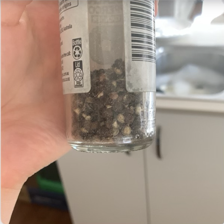

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

{'pepper': 0.9710848927497864,
 'salt': 0.028869593515992165,
 'other': 4.5486664021154866e-05}

In [70]:
# Randomly select an image from all_paths
import random
import glob
# all_paths = glob.glob("food_photos/*/*.jpeg")
# image_path = random.choice(all_paths)
image_path = "pepper-image.png"
display(Image.open(image_path).resize((224, 224)))

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

class_names = ["salt", "pepper", "other"]
open_clip_image_feature_list = open_clip_compute_image_features_of_list([image_path])
bread_text_features = open_clip_compute_text_features(class_names)
open_clip_zero_shot_classification(image_features=open_clip_image_feature_list[0]["image_features"],
                                   text_features=bread_text_features,
                                   class_names=class_names)

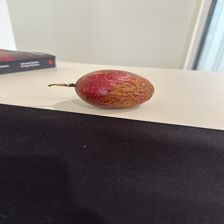

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

{'passionfruit': 0.931300699710846,
 'tamarillo': 0.03499944880604744,
 'lychee': 0.024433549493551254,
 'pomegranate': 0.004449679981917143,
 'plum': 0.0012949308147653937,
 'kiwi_fruit': 0.0008231080719269812,
 'dragonfruit': 0.0007263903389684856,
 'guava': 0.0003710038145072758,
 'mango': 0.00017253281839657575,
 'nectarines': 0.00017253281839657575,
 'onion_red': 0.00015956677088979632,
 'grapes_red': 0.0001302346063312143,
 'figs': 0.0001242707367055118,
 'beetroot': 0.00011857995559694245,
 'pear': 0.00010142681276192889,
 'apple_red': 9.235016477759928e-05,
 'tomato': 8.408578287344426e-05,
 'pawpaw': 6.548607780132443e-05,
 'mandarin': 5.870133827556856e-05,
 'avocado': 5.6895281886681914e-05,
 'chilli': 3.849727363558486e-05,
 'peach': 2.7298656277707778e-05,
 'taro': 2.7298656277707778e-05,
 'eggplant': 1.9357645214768127e-05,
 'grapefruit': 1.6048052202677354e-05,
 'turnip': 1.5313158655771986e-05,
 'ham': 1.4842023119854275e-05,
 'dates': 1.3726625184062868e-05,
 'potato_b

In [71]:
# Randomly select an image from all_paths
import random
import glob
# all_paths = glob.glob("food_photos/*/*.jpeg")
# image_path = random.choice(all_paths)
image_path = "5FD62C55-08D7-48F8-BF76-7CBA8BE0A6C7.jpeg"
display(Image.open(image_path).resize((224, 224)))

# import class_dict.json 
import json
with open("class_dict.json", "r") as f:
    class_dict = json.load(f)

class_names = class_dict.values()

# class_names = ["passionfruit", "other"]
open_clip_image_feature_list = open_clip_compute_image_features_of_list([image_path])
open_clip_text_features = open_clip_compute_text_features(class_names)
open_clip_zero_shot_classification(image_features=open_clip_image_feature_list[0]["image_features"],
                                   text_features=open_clip_text_features,
                                   class_names=class_names)

In [43]:
class_dict

{'0': 'almond_butter',
 '1': 'almonds',
 '2': 'apple_green',
 '3': 'apple_red',
 '4': 'apricot',
 '5': 'asparagus',
 '6': 'avocado',
 '7': 'bacon',
 '8': 'bacon_and_egg_burger',
 '9': 'bagel',
 '10': 'baklava',
 '11': 'banana',
 '12': 'banana_bread',
 '13': 'barbecue_sauce',
 '14': 'beans',
 '15': 'beef',
 '16': 'beef_curry',
 '17': 'beef_mince',
 '18': 'beef_stir_fry',
 '19': 'beer',
 '20': 'beetroot',
 '21': 'biltong',
 '22': 'blackberries',
 '23': 'blueberries',
 '24': 'bok_choy',
 '25': 'bread',
 '26': 'bread_naan',
 '27': 'broccoli',
 '28': 'broccolini',
 '29': 'brownie',
 '30': 'brussel_sprouts',
 '31': 'burrito',
 '32': 'butter',
 '33': 'cabbage',
 '34': 'calamari',
 '35': 'candy',
 '36': 'capsicum',
 '37': 'carrot',
 '38': 'cashews',
 '39': 'cauliflower',
 '40': 'celery',
 '41': 'cheese',
 '42': 'cheeseburger',
 '43': 'cherries',
 '44': 'chicken_breast',
 '45': 'chicken_thighs',
 '46': 'chicken_wings',
 '47': 'chilli',
 '48': 'chimichurri',
 '49': 'chocolate',
 '50': 'chocolate